In [14]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

import scipy.io as sio

# Prepare PA Training data

### Hyper Parameter

In [15]:
P_DPD = 3 #DPD memory length
batch_size = 4096

### Load PA  input/output data

In [16]:
PA_data = sio.loadmat('PA_data.mat')

inDataPA = PA_data['inDataPA']
outDataPA = PA_data['outDataPA']

num_raw_data = inDataPA.size

print(".mat information:")
print("number of raw data:",num_raw_data)
print("inDataPA.shape:",inDataPA.shape)
print("outDataPA.shape:",outDataPA.shape)

.mat information:
number of raw data: 81920
inDataPA.shape: (1, 81920)
outDataPA.shape: (1, 81920)


### Split training data and testing data

In [17]:
num_train_data = int(num_raw_data * 0.5)
num_test_data = num_raw_data-num_train_data
print("number of training data:",num_train_data)
print("number of testing data:",num_test_data)

inDataPA = np.squeeze(inDataPA,axis = 0)
inDataPA_train = inDataPA[:num_train_data]
inDataPA_test = inDataPA[num_train_data:]
outDataPA = np.squeeze(outDataPA,axis = 0)
outDataPA_train = outDataPA[:num_train_data]
outDataPA_test = outDataPA[num_train_data:]

# outDataPA needs to do complex gain normalization to let DPD training have unit gain
complex_gain = np.dot(np.conj(inDataPA_train),np.transpose(outDataPA_train)) / np.dot(np.conj(outDataPA_train),np.transpose(outDataPA_train))
outDataPA_train = outDataPA_train*complex_gain

inDataPA_train_real = np.real(inDataPA_train)
inDataPA_train_imag = np.imag(inDataPA_train)
outDataPA_train_real = np.real(outDataPA_train)
outDataPA_train_imag = np.imag(outDataPA_train)

inDataPA_test_real = np.real(inDataPA_test)
inDataPA_test_imag = np.imag(inDataPA_test)

number of training data: 40960
number of testing data: 40960


### Arrange NN input and NN target 

In [18]:
train_input = np.zeros((num_train_data-P_DPD+1,2*P_DPD))

for i in range(P_DPD):
    train_input[:,i] = outDataPA_train_real[P_DPD-1-i:num_train_data-i]
    train_input[:,i+P_DPD] = outDataPA_train_imag[P_DPD-1-i:num_train_data-i]

train_target = np.zeros((num_train_data-P_DPD+1,2))    
train_target[:,0] = inDataPA_train_real[P_DPD-1:]
train_target[:,1] = inDataPA_train_imag[P_DPD-1:]

# Convert NN input and  NN target to Tensor 
train_input = torch.from_numpy(train_input)
train_target = torch.from_numpy(train_target)

# NN Model

In [19]:
class RVFTDNN(nn.Module):
    def __init__(self):
        super(RVFTDNN,self).__init__() #將nn.Module中的東西用super繼承過來
                      
        self.layer = nn.Sequential(        
            nn.Linear(2*P_DPD, 100),
            #nn.BatchNorm1d(num_neuron),
            #nn.Dropout(0.5),
            nn.ReLU(),         
            nn.Linear(100, 100),
            #nn.Sigmoid(),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 2),
        )            
        
    def forward(self, input):
        output = self.layer(input)        
        return output

# Training and Validation 

### Training and Validation function

In [20]:
train_batch_num = num_train_data//batch_size

def train(model, optimizer):
    
    model.train() #告訴model現在是training(因為像dropout,batch normalization在train和test是不一樣的)
    
    total_train_loss = 0
    for i in range(train_batch_num):
        input = train_input[i*batch_size:(i+1)*batch_size]
        target = train_target[i*batch_size:(i+1)*batch_size]

        input = input.to(device)
        target = target.to(device)
        optimizer.zero_grad()
                
        output = model(input)
        
        # Loss function
        loss = F.mse_loss(output, target)        
        loss_value = loss.item()        
        total_train_loss += loss_value
        
        # do back propagation
        loss.backward()
        optimizer.step()       
         
    return total_train_loss

In [21]:
def valid(model):    
    with torch.no_grad():
        model.eval()
        
        input = train_input
        input = input.to(device)

        output = model(input)
            
    return output

### Model information

In [22]:
# using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RVFTDNN().to(device)
model.double() #將model的paremeter變成double,預設是float,但NN input是double
print(model)

RVFTDNN(
  (layer): Sequential(
    (0): Linear(in_features=6, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)


### Hyper Parameter

In [23]:
epochs = 10000
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr = learning_rate)#,weight_decay = 1e-6)
#optimizer = optim.RMSprop(model.parameters(), lr = learning_rate)

### Start Training and Validation

Epoch:  0 |Train Loss:0.005885103817960304559142592495
train_NMSE: 1.8209243074068349
Epoch:  1 |Train Loss:0.004339014920557221141605985792
train_NMSE: 0.629543884687025
Epoch:  2 |Train Loss:0.003429256180784412497836166622
train_NMSE: -0.09784027868566805
Epoch:  3 |Train Loss:0.003064027222838557485556920668
train_NMSE: -0.3347940783845528
Epoch:  4 |Train Loss:0.002953373040674941302219380646
train_NMSE: -0.46148775521540253
Epoch:  5 |Train Loss:0.002852909979650471682111056992
train_NMSE: -0.6403143214046461
Epoch:  6 |Train Loss:0.002732133956076346001373700290
train_NMSE: -0.8306099615972093
Epoch:  7 |Train Loss:0.002614142693656749515812576234
train_NMSE: -1.029236390155883
Epoch:  8 |Train Loss:0.002489883617107621974207098958
train_NMSE: -1.259615825285549
Epoch:  9 |Train Loss:0.002350583069529868247143911120
train_NMSE: -1.5365452702109357
Epoch: 10 |Train Loss:0.002191859098039514435612984400
train_NMSE: -1.8694924866798825
Epoch: 11 |Train Loss:0.0020244967751283158945

Epoch: 96 |Train Loss:0.000020997005733422541783571302
train_NMSE: -21.896485595746412
Epoch: 97 |Train Loss:0.000020831133079608189718947425
train_NMSE: -21.931632312306498
Epoch: 98 |Train Loss:0.000020661975353910949605110853
train_NMSE: -21.966461052552447
Epoch: 99 |Train Loss:0.000020498274773707960062134673
train_NMSE: -22.00123172287931
Epoch:100 |Train Loss:0.000020334887475284320476013461
train_NMSE: -22.035916552697827
Epoch:101 |Train Loss:0.000020173908190872517144946394
train_NMSE: -22.070620837681766
Epoch:102 |Train Loss:0.000020014273942899009941761082
train_NMSE: -22.105223951329613
Epoch:103 |Train Loss:0.000019855953769815132454751999
train_NMSE: -22.13988814424781
Epoch:104 |Train Loss:0.000019698813864995518322590501
train_NMSE: -22.17459935434928
Epoch:105 |Train Loss:0.000019542920160409934279398952
train_NMSE: -22.209342916541427
Epoch:106 |Train Loss:0.000019388368670799470150920354
train_NMSE: -22.244117599673714
Epoch:107 |Train Loss:0.0000192350202065457783

Epoch:192 |Train Loss:0.000009651211936639507457213853
train_NMSE: -25.299275497891824
Epoch:193 |Train Loss:0.000009574074414274316800060882
train_NMSE: -25.334995574969472
Epoch:194 |Train Loss:0.000009497517697835516949631841
train_NMSE: -25.371038572980808
Epoch:195 |Train Loss:0.000009421148443196653907822334
train_NMSE: -25.406978612781543
Epoch:196 |Train Loss:0.000009345142838383620659302789
train_NMSE: -25.44317930880428
Epoch:197 |Train Loss:0.000009269550295918109125703488
train_NMSE: -25.479318061802097
Epoch:198 |Train Loss:0.000009194461082393857488670452
train_NMSE: -25.5155291415935
Epoch:199 |Train Loss:0.000009119765841697225413633142
train_NMSE: -25.55163230070879
Epoch:200 |Train Loss:0.000009045854182471373090357672
train_NMSE: -25.58791579926134
Epoch:201 |Train Loss:0.000008972154204078664524089036
train_NMSE: -25.6243984338181
Epoch:202 |Train Loss:0.000008898507858757982610887691
train_NMSE: -25.660837877584903
Epoch:203 |Train Loss:0.00000882557774573846015098

Epoch:288 |Train Loss:0.000003641733773524447028357379
train_NMSE: -29.373023442649693
Epoch:289 |Train Loss:0.000003589850027919399438371129
train_NMSE: -29.43430583303694
Epoch:290 |Train Loss:0.000003538443791037679420237710
train_NMSE: -29.49726639058823
Epoch:291 |Train Loss:0.000003487061106728866961043233
train_NMSE: -29.562757709609716
Epoch:292 |Train Loss:0.000003435506025941425997931745
train_NMSE: -29.630685486835734
Epoch:293 |Train Loss:0.000003384237982967657281475676
train_NMSE: -29.699490110903564
Epoch:294 |Train Loss:0.000003333508644887173363212862
train_NMSE: -29.770354503007393
Epoch:295 |Train Loss:0.000003282870205479288686561479
train_NMSE: -29.843381635312532
Epoch:296 |Train Loss:0.000003232191828654773991440306
train_NMSE: -29.91780513533697
Epoch:297 |Train Loss:0.000003182394202057168530040207
train_NMSE: -29.99194404142446
Epoch:298 |Train Loss:0.000003133211269363306017150372
train_NMSE: -30.06746489001955
Epoch:299 |Train Loss:0.000003084354419219891020

Epoch:384 |Train Loss:0.000000965558198868755848036458
train_NMSE: -35.06105870520955
Epoch:385 |Train Loss:0.000000958046884316016774692628
train_NMSE: -35.09235708668853
Epoch:386 |Train Loss:0.000000950795491383322344128640
train_NMSE: -35.12332116099091
Epoch:387 |Train Loss:0.000000943638799790835046483388
train_NMSE: -35.15480380243638
Epoch:388 |Train Loss:0.000000936596341974677024661412
train_NMSE: -35.18496186229718
Epoch:389 |Train Loss:0.000000930013182849032953741254
train_NMSE: -35.211156791022766
Epoch:390 |Train Loss:0.000000923758105600325088206865
train_NMSE: -35.23976522149801
Epoch:391 |Train Loss:0.000000917314332650236585589077
train_NMSE: -35.26882400246509
Epoch:392 |Train Loss:0.000000911138529803223823267560
train_NMSE: -35.294390366608035
Epoch:393 |Train Loss:0.000000905387729349324226088786
train_NMSE: -35.31880379615022
Epoch:394 |Train Loss:0.000000899815326624682198477145
train_NMSE: -35.34431611957612
Epoch:395 |Train Loss:0.0000008942774088017230958567

Epoch:480 |Train Loss:0.000000693797257893091668652468
train_NMSE: -36.38590961409605
Epoch:481 |Train Loss:0.000000692835919114520993473667
train_NMSE: -36.38971470646297
Epoch:482 |Train Loss:0.000000692113239488438761526693
train_NMSE: -36.39164465836325
Epoch:483 |Train Loss:0.000000691175885947151739707771
train_NMSE: -36.39811764194652
Epoch:484 |Train Loss:0.000000690191588872297350895006
train_NMSE: -36.40318635275338
Epoch:485 |Train Loss:0.000000689100381602885654943322
train_NMSE: -36.40858707413982
Epoch:486 |Train Loss:0.000000688246493251995712284565
train_NMSE: -36.41271784284629
Epoch:487 |Train Loss:0.000000687303435192506699912668
train_NMSE: -36.41611194247003
Epoch:488 |Train Loss:0.000000686544379439408990458489
train_NMSE: -36.420112493577776
Epoch:489 |Train Loss:0.000000685725464592792510805266
train_NMSE: -36.422187444722496
Epoch:490 |Train Loss:0.000000684990863821974855752360
train_NMSE: -36.425833601381946
Epoch:491 |Train Loss:0.000000684268782227269634566

Epoch:576 |Train Loss:0.000000628814257922122273417878
train_NMSE: -36.69340917631904
Epoch:577 |Train Loss:0.000000628382083940391970690114
train_NMSE: -36.695995949299714
Epoch:578 |Train Loss:0.000000627766875526790815762281
train_NMSE: -36.700437287680636
Epoch:579 |Train Loss:0.000000627011797926860304825021
train_NMSE: -36.70433247335292
Epoch:580 |Train Loss:0.000000626353183131620501834303
train_NMSE: -36.70666354870151
Epoch:581 |Train Loss:0.000000625730583098465756335853
train_NMSE: -36.710331505601886
Epoch:582 |Train Loss:0.000000625118516920485201293905
train_NMSE: -36.71306965626374
Epoch:583 |Train Loss:0.000000624604362374552108259549
train_NMSE: -36.71665303213671
Epoch:584 |Train Loss:0.000000624263904057260413139072
train_NMSE: -36.71461970264356
Epoch:585 |Train Loss:0.000000623953632526899615984685
train_NMSE: -36.714779032554404
Epoch:586 |Train Loss:0.000000623502225856813811248548
train_NMSE: -36.717359479289726
Epoch:587 |Train Loss:0.0000006230318659402183008

Epoch:672 |Train Loss:0.000000586301355140023804852806
train_NMSE: -37.02822640961499
Epoch:673 |Train Loss:0.000000586011890129840851386010
train_NMSE: -37.03315316930962
Epoch:674 |Train Loss:0.000000585714924967228394560661
train_NMSE: -37.03419172461204
Epoch:675 |Train Loss:0.000000585373419271146120189235
train_NMSE: -37.03868130813965
Epoch:676 |Train Loss:0.000000584877488849548714720751
train_NMSE: -37.04542804339359
Epoch:677 |Train Loss:0.000000584576893255484423189477
train_NMSE: -37.04718153879416
Epoch:678 |Train Loss:0.000000584177221628897834291422
train_NMSE: -37.05281578044228
Epoch:679 |Train Loss:0.000000583719431916152624829843
train_NMSE: -37.05616431181498
Epoch:680 |Train Loss:0.000000583495078779027361715178
train_NMSE: -37.061504382633885
Epoch:681 |Train Loss:0.000000583107430343149385018760
train_NMSE: -37.06427202523352
Epoch:682 |Train Loss:0.000000582637220504896178421329
train_NMSE: -37.07010415530917
Epoch:683 |Train Loss:0.00000058240396615386556066038

Epoch:768 |Train Loss:0.000000557372462669941656085372
train_NMSE: -37.51524443107969
Epoch:769 |Train Loss:0.000000557213159667146888471211
train_NMSE: -37.52054699797559
Epoch:770 |Train Loss:0.000000556897126577408881276847
train_NMSE: -37.52537553600371
Epoch:771 |Train Loss:0.000000556634626608175612828844
train_NMSE: -37.53074352529721
Epoch:772 |Train Loss:0.000000556446231736154927649573
train_NMSE: -37.53593176762549
Epoch:773 |Train Loss:0.000000556179491704793987880725
train_NMSE: -37.540241789916266
Epoch:774 |Train Loss:0.000000555894597920918079140011
train_NMSE: -37.54550887054367
Epoch:775 |Train Loss:0.000000555717571085837927590651
train_NMSE: -37.55012029074093
Epoch:776 |Train Loss:0.000000555574501338465114503890
train_NMSE: -37.553500050366715
Epoch:777 |Train Loss:0.000000555239594781040342803314
train_NMSE: -37.559455998140436
Epoch:778 |Train Loss:0.000000555005632688778580899195
train_NMSE: -37.56567479564028
Epoch:779 |Train Loss:0.000000554679637950653552796

Epoch:864 |Train Loss:0.000000536145590961195661174944
train_NMSE: -37.95931025876846
Epoch:865 |Train Loss:0.000000536065095384296363377745
train_NMSE: -37.96099767408511
Epoch:866 |Train Loss:0.000000536005486749897991913868
train_NMSE: -37.96360961613742
Epoch:867 |Train Loss:0.000000535685610168330974756247
train_NMSE: -37.96664098148144
Epoch:868 |Train Loss:0.000000535467617871785104083034
train_NMSE: -37.97115119299306
Epoch:869 |Train Loss:0.000000535426364953564826786665
train_NMSE: -37.974381498026595
Epoch:870 |Train Loss:0.000000535389267770444565386280
train_NMSE: -37.97409093479884
Epoch:871 |Train Loss:0.000000535072460043169367926010
train_NMSE: -37.978913980162986
Epoch:872 |Train Loss:0.000000534600519446355035565002
train_NMSE: -37.98602639117745
Epoch:873 |Train Loss:0.000000534463363433071540696778
train_NMSE: -37.9895414477555
Epoch:874 |Train Loss:0.000000534424611697841369346656
train_NMSE: -37.9899711053594
Epoch:875 |Train Loss:0.000000534051669088879604264160

Epoch:960 |Train Loss:0.000000514663484361321401603382
train_NMSE: -38.266591553962826
Epoch:961 |Train Loss:0.000000514224706288298601686575
train_NMSE: -38.273039121263224
Epoch:962 |Train Loss:0.000000514089687804352276357376
train_NMSE: -38.276968040430816
Epoch:963 |Train Loss:0.000000513859081937203388120924
train_NMSE: -38.281047808762274
Epoch:964 |Train Loss:0.000000513552939183157967463283
train_NMSE: -38.28568520725926
Epoch:965 |Train Loss:0.000000513160319542026298892312
train_NMSE: -38.291609166430604
Epoch:966 |Train Loss:0.000000512750840725949334642105
train_NMSE: -38.2983158806337
Epoch:967 |Train Loss:0.000000512626104797221805613237
train_NMSE: -38.30353836495952
Epoch:968 |Train Loss:0.000000512317319623701262560267
train_NMSE: -38.31034719007232
Epoch:969 |Train Loss:0.000000512171131513204067097281
train_NMSE: -38.31416821822349
Epoch:970 |Train Loss:0.000000512158405117129131431039
train_NMSE: -38.31786407031728
Epoch:971 |Train Loss:0.00000051212699794338138948

Epoch:1056 |Train Loss:0.000000495906976275985661979195
train_NMSE: -38.6328618314886
Epoch:1057 |Train Loss:0.000000495640282294053920228557
train_NMSE: -38.63695230801457
Epoch:1058 |Train Loss:0.000000495360755106461237641156
train_NMSE: -38.639809277616166
Epoch:1059 |Train Loss:0.000000495105123581885146668430
train_NMSE: -38.644255566661386
Epoch:1060 |Train Loss:0.000000494887384339804412259581
train_NMSE: -38.64875562103308
Epoch:1061 |Train Loss:0.000000495031082635787602635080
train_NMSE: -38.6488470109678
Epoch:1062 |Train Loss:0.000000494867787218012572162231
train_NMSE: -38.65019536659061
Epoch:1063 |Train Loss:0.000000494629499582455494638010
train_NMSE: -38.6524870810156
Epoch:1064 |Train Loss:0.000000494404018338667539233925
train_NMSE: -38.65640710289567
Epoch:1065 |Train Loss:0.000000494262833150851101785060
train_NMSE: -38.6614637523702
Epoch:1066 |Train Loss:0.000000494160610360079650083215
train_NMSE: -38.66270862899843
Epoch:1067 |Train Loss:0.00000049413216309217

Epoch:1152 |Train Loss:0.000000479373704619371693271739
train_NMSE: -38.855197409098594
Epoch:1153 |Train Loss:0.000000479200267293532827752765
train_NMSE: -38.85565785345368
Epoch:1154 |Train Loss:0.000000479021581267957101045939
train_NMSE: -38.86100338718274
Epoch:1155 |Train Loss:0.000000478953406267307667769492
train_NMSE: -38.860600044807036
Epoch:1156 |Train Loss:0.000000478748030557865874387460
train_NMSE: -38.86100653499685
Epoch:1157 |Train Loss:0.000000478558410063359726602098
train_NMSE: -38.86489779826336
Epoch:1158 |Train Loss:0.000000478445135924740259819360
train_NMSE: -38.86710945743804
Epoch:1159 |Train Loss:0.000000478426580101194614253585
train_NMSE: -38.864872749257735
Epoch:1160 |Train Loss:0.000000478227874417458102303388
train_NMSE: -38.864508816583474
Epoch:1161 |Train Loss:0.000000477758496629078143220636
train_NMSE: -38.8689663117031
Epoch:1162 |Train Loss:0.000000477624627108871540794456
train_NMSE: -38.872990738905486
Epoch:1163 |Train Loss:0.00000047777850

Epoch:1248 |Train Loss:0.000000465808052663333776495383
train_NMSE: -39.04344219343523
Epoch:1249 |Train Loss:0.000000465666928891712598792075
train_NMSE: -39.0490129727636
Epoch:1250 |Train Loss:0.000000465673362419632913451219
train_NMSE: -39.044622522767355
Epoch:1251 |Train Loss:0.000000465584582067124517727058
train_NMSE: -39.045812633441656
Epoch:1252 |Train Loss:0.000000465289718594373648877352
train_NMSE: -39.0512800632113
Epoch:1253 |Train Loss:0.000000465350283410568293403350
train_NMSE: -39.052813507854125
Epoch:1254 |Train Loss:0.000000465179858859799799890837
train_NMSE: -39.05055671925817
Epoch:1255 |Train Loss:0.000000464947399233663599773966
train_NMSE: -39.05532812221051
Epoch:1256 |Train Loss:0.000000464874289895315043196644
train_NMSE: -39.05863314787205
Epoch:1257 |Train Loss:0.000000464807932532355714400334
train_NMSE: -39.05622505415528
Epoch:1258 |Train Loss:0.000000464776346568510451910238
train_NMSE: -39.05811011058724
Epoch:1259 |Train Loss:0.00000046467924801

Epoch:1344 |Train Loss:0.000000455448773495185004586054
train_NMSE: -39.13187882770367
Epoch:1345 |Train Loss:0.000000455199567967642621100675
train_NMSE: -39.132561072328265
Epoch:1346 |Train Loss:0.000000454844891363012350224469
train_NMSE: -39.13538099580566
Epoch:1347 |Train Loss:0.000000454822327312713727661601
train_NMSE: -39.13438412814438
Epoch:1348 |Train Loss:0.000000454833678610746758719778
train_NMSE: -39.13542310613804
Epoch:1349 |Train Loss:0.000000454598492383195313164078
train_NMSE: -39.13780741155355
Epoch:1350 |Train Loss:0.000000454455465536508731208250
train_NMSE: -39.14121077099046
Epoch:1351 |Train Loss:0.000000454517650425870823120667
train_NMSE: -39.13802680747615
Epoch:1352 |Train Loss:0.000000454488045995012611585445
train_NMSE: -39.14037863588186
Epoch:1353 |Train Loss:0.000000454318905372668456622137
train_NMSE: -39.139723950272696
Epoch:1354 |Train Loss:0.000000454177637313210985039091
train_NMSE: -39.14099334956675
Epoch:1355 |Train Loss:0.0000004545169083

Epoch:1440 |Train Loss:0.000000445977378226604651648157
train_NMSE: -39.21800481221663
Epoch:1441 |Train Loss:0.000000446070494716209411995196
train_NMSE: -39.21303160366331
Epoch:1442 |Train Loss:0.000000445926931931284887090179
train_NMSE: -39.216762586427365
Epoch:1443 |Train Loss:0.000000445778878030390395768970
train_NMSE: -39.214765452615666
Epoch:1444 |Train Loss:0.000000445866778189222415881463
train_NMSE: -39.215832627285444
Epoch:1445 |Train Loss:0.000000445788907084448313817936
train_NMSE: -39.21561542282931
Epoch:1446 |Train Loss:0.000000445673444910765445705183
train_NMSE: -39.2172876182179
Epoch:1447 |Train Loss:0.000000445630871653701949045636
train_NMSE: -39.21557350312119
Epoch:1448 |Train Loss:0.000000445458636410532089014186
train_NMSE: -39.21680918444909
Epoch:1449 |Train Loss:0.000000445794003954044428643941
train_NMSE: -39.21043003565323
Epoch:1450 |Train Loss:0.000000445106144805355467026912
train_NMSE: -39.21843581345192
Epoch:1451 |Train Loss:0.0000004452072961

Epoch:1536 |Train Loss:0.000000437716506760508276227425
train_NMSE: -39.30096044687512
Epoch:1537 |Train Loss:0.000000437384080469414905921092
train_NMSE: -39.30098606775806
Epoch:1538 |Train Loss:0.000000436826858550585721620329
train_NMSE: -39.30990387847649
Epoch:1539 |Train Loss:0.000000437594976842320837659135
train_NMSE: -39.30268814236694
Epoch:1540 |Train Loss:0.000000437509908022884383699410
train_NMSE: -39.30121913486921
Epoch:1541 |Train Loss:0.000000437191326509231554263738
train_NMSE: -39.30210392900607
Epoch:1542 |Train Loss:0.000000436624117099308002495759
train_NMSE: -39.307102247657454
Epoch:1543 |Train Loss:0.000000437154768257077627661522
train_NMSE: -39.304734367075156
Epoch:1544 |Train Loss:0.000000437299465439482458813694
train_NMSE: -39.301095514708514
Epoch:1545 |Train Loss:0.000000436936627947135182300175
train_NMSE: -39.302422400119724
Epoch:1546 |Train Loss:0.000000436836613404278696128904
train_NMSE: -39.30202169477453
Epoch:1547 |Train Loss:0.00000043638252

Epoch:1632 |Train Loss:0.000000430140217140858884519182
train_NMSE: -39.345517750445126
Epoch:1633 |Train Loss:0.000000429787895334938611805413
train_NMSE: -39.35052686058593
Epoch:1634 |Train Loss:0.000000430337218705785432829367
train_NMSE: -39.34456313866306
Epoch:1635 |Train Loss:0.000000430220591133063764212882
train_NMSE: -39.343004533311266
Epoch:1636 |Train Loss:0.000000429748634446616929668676
train_NMSE: -39.34726512794013
Epoch:1637 |Train Loss:0.000000429616251052875989717786
train_NMSE: -39.34674944631071
Epoch:1638 |Train Loss:0.000000429602303617740041562928
train_NMSE: -39.349672256748384
Epoch:1639 |Train Loss:0.000000429492306336347006427728
train_NMSE: -39.34788869400052
Epoch:1640 |Train Loss:0.000000429121393715850563641294
train_NMSE: -39.35222711179971
Epoch:1641 |Train Loss:0.000000429597310563949472198415
train_NMSE: -39.34672613935162
Epoch:1642 |Train Loss:0.000000429317344477531112168867
train_NMSE: -39.34838517165679
Epoch:1643 |Train Loss:0.000000428998236

Epoch:1728 |Train Loss:0.000000423090529892889377347259
train_NMSE: -39.395073098405405
Epoch:1729 |Train Loss:0.000000422876808011724842224890
train_NMSE: -39.393791335444035
Epoch:1730 |Train Loss:0.000000422225687678451594094415
train_NMSE: -39.40079914679296
Epoch:1731 |Train Loss:0.000000422783156675551330360688
train_NMSE: -39.39538182166819
Epoch:1732 |Train Loss:0.000000422651410488138386250542
train_NMSE: -39.39462272897651
Epoch:1733 |Train Loss:0.000000422286489723852360978867
train_NMSE: -39.39703369489644
Epoch:1734 |Train Loss:0.000000422083250181648348337205
train_NMSE: -39.399186398696344
Epoch:1735 |Train Loss:0.000000422645763377111692956956
train_NMSE: -39.396087668365915
Epoch:1736 |Train Loss:0.000000422159465069041266286509
train_NMSE: -39.397022911833226
Epoch:1737 |Train Loss:0.000000421643822612388994967598
train_NMSE: -39.40202696162655
Epoch:1738 |Train Loss:0.000000422163304397415508111490
train_NMSE: -39.40038507070217
Epoch:1739 |Train Loss:0.0000004220311

Epoch:1824 |Train Loss:0.000000415613078151465103897059
train_NMSE: -39.45393506537149
Epoch:1825 |Train Loss:0.000000415214747766740508545872
train_NMSE: -39.46011596805793
Epoch:1826 |Train Loss:0.000000415635510221292068685735
train_NMSE: -39.457943220421626
Epoch:1827 |Train Loss:0.000000415408796526969595828396
train_NMSE: -39.45500302985991
Epoch:1828 |Train Loss:0.000000414916170200891269687722
train_NMSE: -39.46445871221184
Epoch:1829 |Train Loss:0.000000415387967973778774974944
train_NMSE: -39.45934172635435
Epoch:1830 |Train Loss:0.000000414899695288608578140491
train_NMSE: -39.46266507098541
Epoch:1831 |Train Loss:0.000000415053644325406537726931
train_NMSE: -39.46170724897429
Epoch:1832 |Train Loss:0.000000414571047723252395092393
train_NMSE: -39.46798908209719
Epoch:1833 |Train Loss:0.000000414993321080305303294905
train_NMSE: -39.464278299837986
Epoch:1834 |Train Loss:0.000000414539078395203387051243
train_NMSE: -39.46854626352105
Epoch:1835 |Train Loss:0.0000004147644812

Epoch:1920 |Train Loss:0.000000408808249854404324521182
train_NMSE: -39.52846654528305
Epoch:1921 |Train Loss:0.000000408922239571544964557615
train_NMSE: -39.52801560204324
Epoch:1922 |Train Loss:0.000000408742466803010359861873
train_NMSE: -39.526483880269716
Epoch:1923 |Train Loss:0.000000408532303126728049215736
train_NMSE: -39.53186561187661
Epoch:1924 |Train Loss:0.000000408773431488046757617218
train_NMSE: -39.53034820062411
Epoch:1925 |Train Loss:0.000000408722137496348435541582
train_NMSE: -39.52995975900853
Epoch:1926 |Train Loss:0.000000408390839078959503651180
train_NMSE: -39.534291437525575
Epoch:1927 |Train Loss:0.000000408418288179840060642394
train_NMSE: -39.53517988820428
Epoch:1928 |Train Loss:0.000000408445755572945620363130
train_NMSE: -39.53313576683138
Epoch:1929 |Train Loss:0.000000408220368608041539184125
train_NMSE: -39.53822612716941
Epoch:1930 |Train Loss:0.000000408392059515684375918949
train_NMSE: -39.536216339478834
Epoch:1931 |Train Loss:0.000000408189179

Epoch:2016 |Train Loss:0.000000402451364684992982075014
train_NMSE: -39.58908936371894
Epoch:2017 |Train Loss:0.000000402710164868453560359533
train_NMSE: -39.58679114855516
Epoch:2018 |Train Loss:0.000000402329417647503304808894
train_NMSE: -39.5885453004228
Epoch:2019 |Train Loss:0.000000402287634194501559735927
train_NMSE: -39.59130061258418
Epoch:2020 |Train Loss:0.000000402413756540901351141425
train_NMSE: -39.59056381602572
Epoch:2021 |Train Loss:0.000000402379554082434097435448
train_NMSE: -39.589120927705494
Epoch:2022 |Train Loss:0.000000402442560688468026719683
train_NMSE: -39.585943785825904
Epoch:2023 |Train Loss:0.000000402250075540186685387715
train_NMSE: -39.590817913295545
Epoch:2024 |Train Loss:0.000000402146326624134478143599
train_NMSE: -39.59620668329658
Epoch:2025 |Train Loss:0.000000402242360886201780836190
train_NMSE: -39.59146482195996
Epoch:2026 |Train Loss:0.000000402097446629093679921563
train_NMSE: -39.593585064224676
Epoch:2027 |Train Loss:0.000000402148454

Epoch:2112 |Train Loss:0.000000397020319052880726802432
train_NMSE: -39.63106359849166
Epoch:2113 |Train Loss:0.000000397166995659167399449407
train_NMSE: -39.625166270164996
Epoch:2114 |Train Loss:0.000000396912930316976311686389
train_NMSE: -39.6292347562679
Epoch:2115 |Train Loss:0.000000397058397156527604151969
train_NMSE: -39.630094300257596
Epoch:2116 |Train Loss:0.000000396811424615541908262088
train_NMSE: -39.629554051384005
Epoch:2117 |Train Loss:0.000000396622074489085790371826
train_NMSE: -39.63283857799403
Epoch:2118 |Train Loss:0.000000396563380612970616566142
train_NMSE: -39.633752523046915
Epoch:2119 |Train Loss:0.000000396633178323868300926505
train_NMSE: -39.63703505145095
Epoch:2120 |Train Loss:0.000000396509583778931251164606
train_NMSE: -39.6321580160924
Epoch:2121 |Train Loss:0.000000396374852842656559494852
train_NMSE: -39.633006767617005
Epoch:2122 |Train Loss:0.000000396252083932068811806252
train_NMSE: -39.64142664191809
Epoch:2123 |Train Loss:0.000000396394360

Epoch:2208 |Train Loss:0.000000392101112515854639723769
train_NMSE: -39.65446660408211
Epoch:2209 |Train Loss:0.000000392245742257479640406517
train_NMSE: -39.64613999794162
Epoch:2210 |Train Loss:0.000000392099741470962320060432
train_NMSE: -39.65787016736996
Epoch:2211 |Train Loss:0.000000392088847795593971897707
train_NMSE: -39.64195952150019
Epoch:2212 |Train Loss:0.000000391722399331498503619069
train_NMSE: -39.65474136463011
Epoch:2213 |Train Loss:0.000000392071318907408297178553
train_NMSE: -39.64151984800071
Epoch:2214 |Train Loss:0.000000391685356619730620970649
train_NMSE: -39.657506081493786
Epoch:2215 |Train Loss:0.000000392241130216961712395135
train_NMSE: -39.64104174877222
Epoch:2216 |Train Loss:0.000000391538536233263298853646
train_NMSE: -39.65141032745815
Epoch:2217 |Train Loss:0.000000391994495481473543376162
train_NMSE: -39.640435167545064
Epoch:2218 |Train Loss:0.000000391567711921741478150988
train_NMSE: -39.653827518226855
Epoch:2219 |Train Loss:0.000000392178129

Epoch:2304 |Train Loss:0.000000387238756918474676419292
train_NMSE: -39.627558064024925
Epoch:2305 |Train Loss:0.000000387668248414887564260855
train_NMSE: -39.61403011308448
Epoch:2306 |Train Loss:0.000000387104349008552563177329
train_NMSE: -39.63206774400393
Epoch:2307 |Train Loss:0.000000387977287330701530896157
train_NMSE: -39.61244852214498
Epoch:2308 |Train Loss:0.000000386923103033480518714754
train_NMSE: -39.62561613363552
Epoch:2309 |Train Loss:0.000000387542020815987029210687
train_NMSE: -39.61043165320011
Epoch:2310 |Train Loss:0.000000387091236626544385761219
train_NMSE: -39.62836509806681
Epoch:2311 |Train Loss:0.000000387619582259154645497817
train_NMSE: -39.61104696612977
Epoch:2312 |Train Loss:0.000000386650739542372896459364
train_NMSE: -39.62604770824325
Epoch:2313 |Train Loss:0.000000387475976584388558164682
train_NMSE: -39.6091646667208
Epoch:2314 |Train Loss:0.000000386713188815017401750630
train_NMSE: -39.62698235650678
Epoch:2315 |Train Loss:0.000000387413782026

Epoch:2400 |Train Loss:0.000000382099584870963467689151
train_NMSE: -39.685106213140934
Epoch:2401 |Train Loss:0.000000382769342615135311991905
train_NMSE: -39.668411375046524
Epoch:2402 |Train Loss:0.000000381974128849842361110091
train_NMSE: -39.684578061389
Epoch:2403 |Train Loss:0.000000382845419959322909861984
train_NMSE: -39.668826824274966
Epoch:2404 |Train Loss:0.000000381904982135986499278813
train_NMSE: -39.686598480402814
Epoch:2405 |Train Loss:0.000000382781393892762523404103
train_NMSE: -39.66984753895258
Epoch:2406 |Train Loss:0.000000381895232113628054346135
train_NMSE: -39.68379315713491
Epoch:2407 |Train Loss:0.000000382614326281888890989599
train_NMSE: -39.66998853977964
Epoch:2408 |Train Loss:0.000000381816786701937899053527
train_NMSE: -39.68517734973005
Epoch:2409 |Train Loss:0.000000382456732662967925282221
train_NMSE: -39.67143913770267
Epoch:2410 |Train Loss:0.000000381680410907202321933859
train_NMSE: -39.68865952040909
Epoch:2411 |Train Loss:0.0000003824689191

Epoch:2496 |Train Loss:0.000000377770048417926786715585
train_NMSE: -39.72961773608621
Epoch:2497 |Train Loss:0.000000378599414179104700318139
train_NMSE: -39.71251134572489
Epoch:2498 |Train Loss:0.000000377603220896839570248091
train_NMSE: -39.729726694531095
Epoch:2499 |Train Loss:0.000000378570067295482903380456
train_NMSE: -39.71318773480497
Epoch:2500 |Train Loss:0.000000377565517143900153397530
train_NMSE: -39.730252219072625
Epoch:2501 |Train Loss:0.000000378394374912955589406426
train_NMSE: -39.71350673957065
Epoch:2502 |Train Loss:0.000000377410108340385759090964
train_NMSE: -39.73013457659438
Epoch:2503 |Train Loss:0.000000378327091882825392570321
train_NMSE: -39.713880645329
Epoch:2504 |Train Loss:0.000000377321476435218922510005
train_NMSE: -39.730361551701876
Epoch:2505 |Train Loss:0.000000378255049608586859894528
train_NMSE: -39.715337326252474
Epoch:2506 |Train Loss:0.000000377310512082531170881337
train_NMSE: -39.73009628486828
Epoch:2507 |Train Loss:0.0000003780211083

Epoch:2592 |Train Loss:0.000000373042406781481017727766
train_NMSE: -39.7710650025915
Epoch:2593 |Train Loss:0.000000373898477602385334850186
train_NMSE: -39.75948498469501
Epoch:2594 |Train Loss:0.000000373030623249713818786344
train_NMSE: -39.771290915302366
Epoch:2595 |Train Loss:0.000000373798629865330528290729
train_NMSE: -39.76134432339752
Epoch:2596 |Train Loss:0.000000373025241987399959213472
train_NMSE: -39.77276642638663
Epoch:2597 |Train Loss:0.000000373706788324381985186214
train_NMSE: -39.7617471152987
Epoch:2598 |Train Loss:0.000000372901400653883713496342
train_NMSE: -39.77337823252361
Epoch:2599 |Train Loss:0.000000373697897772639432314556
train_NMSE: -39.761039477375164
Epoch:2600 |Train Loss:0.000000372773503537207641661425
train_NMSE: -39.77399334385577
Epoch:2601 |Train Loss:0.000000373666607833289212935710
train_NMSE: -39.76252529665983
Epoch:2602 |Train Loss:0.000000372797623948351226387532
train_NMSE: -39.77519728083746
Epoch:2603 |Train Loss:0.000000373496933527

Epoch:2688 |Train Loss:0.000000369935546807100087397070
train_NMSE: -39.75281470416613
Epoch:2689 |Train Loss:0.000000370961769318456375755719
train_NMSE: -39.73492416043238
Epoch:2690 |Train Loss:0.000000369982096006433494556298
train_NMSE: -39.747385852017175
Epoch:2691 |Train Loss:0.000000370898958694036189757731
train_NMSE: -39.72982492087384
Epoch:2692 |Train Loss:0.000000369940273550788071122255
train_NMSE: -39.74280398697175
Epoch:2693 |Train Loss:0.000000370864795921225890002571
train_NMSE: -39.72637669207829
Epoch:2694 |Train Loss:0.000000369862534511132170350883
train_NMSE: -39.74065209462956
Epoch:2695 |Train Loss:0.000000370739181041803977821267
train_NMSE: -39.72184822140382
Epoch:2696 |Train Loss:0.000000369723638288268307163615
train_NMSE: -39.73558822550393
Epoch:2697 |Train Loss:0.000000370751373974577857032950
train_NMSE: -39.718192733718695
Epoch:2698 |Train Loss:0.000000369840821945549227148199
train_NMSE: -39.732786157993786
Epoch:2699 |Train Loss:0.000000370701816

Epoch:2784 |Train Loss:0.000000365226588021041310578441
train_NMSE: -39.737670562779805
Epoch:2785 |Train Loss:0.000000366217769643792698649527
train_NMSE: -39.72157583075771
Epoch:2786 |Train Loss:0.000000365263234035628649200165
train_NMSE: -39.740052944145425
Epoch:2787 |Train Loss:0.000000366155510439737163727749
train_NMSE: -39.726151230402174
Epoch:2788 |Train Loss:0.000000365051343112371471534816
train_NMSE: -39.74464163054978
Epoch:2789 |Train Loss:0.000000365966142596713451286939
train_NMSE: -39.72956831379362
Epoch:2790 |Train Loss:0.000000364911538609033123962066
train_NMSE: -39.74973725598046
Epoch:2791 |Train Loss:0.000000365907214435726431261151
train_NMSE: -39.735956231996774
Epoch:2792 |Train Loss:0.000000364858087129211853670319
train_NMSE: -39.7536385097957
Epoch:2793 |Train Loss:0.000000365771485374671325315713
train_NMSE: -39.73963062141098
Epoch:2794 |Train Loss:0.000000364761325234772843995501
train_NMSE: -39.7572780261341
Epoch:2795 |Train Loss:0.0000003656643734

Epoch:2880 |Train Loss:0.000000364157007089760288483796
train_NMSE: -39.7921851438369
Epoch:2881 |Train Loss:0.000000364641254934496521341800
train_NMSE: -39.77982895285038
Epoch:2882 |Train Loss:0.000000364318135561953189626653
train_NMSE: -39.77986354870501
Epoch:2883 |Train Loss:0.000000364685742243470228356325
train_NMSE: -39.77135318075929
Epoch:2884 |Train Loss:0.000000364568360712496502096209
train_NMSE: -39.768623676467996
Epoch:2885 |Train Loss:0.000000364609411277849691169670
train_NMSE: -39.75324265547083
Epoch:2886 |Train Loss:0.000000364644756444159681137385
train_NMSE: -39.758309773745374
Epoch:2887 |Train Loss:0.000000365014619702133281625933
train_NMSE: -39.74536909778512
Epoch:2888 |Train Loss:0.000000364459386515462977345909
train_NMSE: -39.74467611297956
Epoch:2889 |Train Loss:0.000000364771100082094032768671
train_NMSE: -39.73429718235271
Epoch:2890 |Train Loss:0.000000364932992448321648450485
train_NMSE: -39.73058393907253
Epoch:2891 |Train Loss:0.00000036504106709

Epoch:2976 |Train Loss:0.000000358126665804009143224864
train_NMSE: -39.57628653410185
Epoch:2977 |Train Loss:0.000000357479410102602026728810
train_NMSE: -39.57827934973277
Epoch:2978 |Train Loss:0.000000357112493824918230688500
train_NMSE: -39.595508770783695
Epoch:2979 |Train Loss:0.000000357956646613639973646115
train_NMSE: -39.59121585700275
Epoch:2980 |Train Loss:0.000000357314380926346857135484
train_NMSE: -39.603368726366845
Epoch:2981 |Train Loss:0.000000357299429116024293265119
train_NMSE: -39.60857960369917
Epoch:2982 |Train Loss:0.000000357299397098107312768523
train_NMSE: -39.62088129665311
Epoch:2983 |Train Loss:0.000000357128049648736432173074
train_NMSE: -39.618100086549866
Epoch:2984 |Train Loss:0.000000356775435570545464940425
train_NMSE: -39.63884608066837
Epoch:2985 |Train Loss:0.000000357071036719181853613642
train_NMSE: -39.633208453588075
Epoch:2986 |Train Loss:0.000000356504545988036264382549
train_NMSE: -39.65197107131844
Epoch:2987 |Train Loss:0.00000035683919

Epoch:3072 |Train Loss:0.000000318021235297915428680082
train_NMSE: -40.97661347013171
Epoch:3073 |Train Loss:0.000000317126053762077935485294
train_NMSE: -40.97492965371381
Epoch:3074 |Train Loss:0.000000316169205034447750877401
train_NMSE: -40.97240130126144
Epoch:3075 |Train Loss:0.000000315264206314642236173826
train_NMSE: -40.96936696887006
Epoch:3076 |Train Loss:0.000000314444719207020484474469
train_NMSE: -40.966348298815745
Epoch:3077 |Train Loss:0.000000313774749449151242506825
train_NMSE: -40.962598836694035
Epoch:3078 |Train Loss:0.000000313066209702940198270256
train_NMSE: -40.95926585895609
Epoch:3079 |Train Loss:0.000000312434786225516853811781
train_NMSE: -40.955766520009355
Epoch:3080 |Train Loss:0.000000311806057796297766081771
train_NMSE: -40.95288287465793
Epoch:3081 |Train Loss:0.000000311208199402555608119916
train_NMSE: -40.94987815994951
Epoch:3082 |Train Loss:0.000000310912152192832973560306
train_NMSE: -40.94479014859469
Epoch:3083 |Train Loss:0.000000310337389

Epoch:3168 |Train Loss:0.000000315172778668553153927714
train_NMSE: -40.6951152091506
Epoch:3169 |Train Loss:0.000000315671070265745771622030
train_NMSE: -40.69659717733628
Epoch:3170 |Train Loss:0.000000315717872250810407034987
train_NMSE: -40.69023848456705
Epoch:3171 |Train Loss:0.000000315852077696107163839480
train_NMSE: -40.68974940693672
Epoch:3172 |Train Loss:0.000000316056390856368011218179
train_NMSE: -40.684840096995586
Epoch:3173 |Train Loss:0.000000316410027521035169417610
train_NMSE: -40.68728742974922
Epoch:3174 |Train Loss:0.000000316889076109420679580559
train_NMSE: -40.68566173650836
Epoch:3175 |Train Loss:0.000000317074365865822121371539
train_NMSE: -40.67429316654983
Epoch:3176 |Train Loss:0.000000317246462293409872737731
train_NMSE: -40.67861760842281
Epoch:3177 |Train Loss:0.000000317418204867014814501096
train_NMSE: -40.68852451992616
Epoch:3178 |Train Loss:0.000000317565056039785100901006
train_NMSE: -40.67782439440797
Epoch:3179 |Train Loss:0.000000317578898558

Epoch:3264 |Train Loss:0.000000318010750364921269793409
train_NMSE: -40.38896650899996
Epoch:3265 |Train Loss:0.000000318281913847962214766566
train_NMSE: -40.3754279044439
Epoch:3266 |Train Loss:0.000000317964722690281558878009
train_NMSE: -40.36089116084626
Epoch:3267 |Train Loss:0.000000318662283305328264977738
train_NMSE: -40.37504276941718
Epoch:3268 |Train Loss:0.000000318493016728635923010590
train_NMSE: -40.34924209345434
Epoch:3269 |Train Loss:0.000000318385592433188880453923
train_NMSE: -40.338986435215205
Epoch:3270 |Train Loss:0.000000319007608766236381207619
train_NMSE: -40.351134059984936
Epoch:3271 |Train Loss:0.000000318965941906043135279346
train_NMSE: -40.3264143365638
Epoch:3272 |Train Loss:0.000000318628654154639710990567
train_NMSE: -40.309335617832886
Epoch:3273 |Train Loss:0.000000319111979830126787289796
train_NMSE: -40.32313094499819
Epoch:3274 |Train Loss:0.000000319350232079353122339793
train_NMSE: -40.30146331495069
Epoch:3275 |Train Loss:0.00000031899172577

Epoch:3360 |Train Loss:0.000000316038049225680950262400
train_NMSE: -40.96090028172074
Epoch:3361 |Train Loss:0.000000316353325545641301754949
train_NMSE: -40.9748583468652
Epoch:3362 |Train Loss:0.000000316351385928050475982007
train_NMSE: -40.98636259419696
Epoch:3363 |Train Loss:0.000000316344894274447202214633
train_NMSE: -41.00090307864768
Epoch:3364 |Train Loss:0.000000316678503316925235475620
train_NMSE: -41.00868420714696
Epoch:3365 |Train Loss:0.000000316799069340831965028418
train_NMSE: -41.020634151207354
Epoch:3366 |Train Loss:0.000000316860047986260922274872
train_NMSE: -41.03434729225704
Epoch:3367 |Train Loss:0.000000317295306849598591799857
train_NMSE: -41.042881278089126
Epoch:3368 |Train Loss:0.000000317513634027240727795126
train_NMSE: -41.04677063296619
Epoch:3369 |Train Loss:0.000000317112018474951622979053
train_NMSE: -41.05159622571965
Epoch:3370 |Train Loss:0.000000317582262103753875027339
train_NMSE: -41.05053270941501
Epoch:3371 |Train Loss:0.00000031833520661

Epoch:3456 |Train Loss:0.000000316530260296016554300035
train_NMSE: -40.08391692351654
Epoch:3457 |Train Loss:0.000000316675775912273728353221
train_NMSE: -40.06200314121594
Epoch:3458 |Train Loss:0.000000317764838981462933968641
train_NMSE: -40.06844714103166
Epoch:3459 |Train Loss:0.000000317311399080641050200123
train_NMSE: -40.02696785805031
Epoch:3460 |Train Loss:0.000000317128376629712476672790
train_NMSE: -39.982912824979245
Epoch:3461 |Train Loss:0.000000318084031280824679257391
train_NMSE: -39.979866053580146
Epoch:3462 |Train Loss:0.000000318237683830401437581436
train_NMSE: -39.95344419750747
Epoch:3463 |Train Loss:0.000000317664186505032957042588
train_NMSE: -39.88432610089382
Epoch:3464 |Train Loss:0.000000318659071478432466073896
train_NMSE: -39.86267788817177
Epoch:3465 |Train Loss:0.000000319621997206868253376929
train_NMSE: -39.83993186688259
Epoch:3466 |Train Loss:0.000000319112860862119452914248
train_NMSE: -39.75649461055048
Epoch:3467 |Train Loss:0.0000003200622816

Epoch:3552 |Train Loss:0.000000315693397656162255840120
train_NMSE: -40.24670550894786
Epoch:3553 |Train Loss:0.000000294405400742517912517662
train_NMSE: -40.46056917263763
Epoch:3554 |Train Loss:0.000000292782337274769082975689
train_NMSE: -40.71124318589633
Epoch:3555 |Train Loss:0.000000296024349841462408343195
train_NMSE: -40.862150739921944
Epoch:3556 |Train Loss:0.000000297704915859016306822380
train_NMSE: -40.92598720098029
Epoch:3557 |Train Loss:0.000000296320103540816930233714
train_NMSE: -40.94169542565765
Epoch:3558 |Train Loss:0.000000296023607900894589283587
train_NMSE: -40.93500440875373
Epoch:3559 |Train Loss:0.000000296888083794775555270955
train_NMSE: -40.913677151618224
Epoch:3560 |Train Loss:0.000000299312428095127058693905
train_NMSE: -40.89736890849807
Epoch:3561 |Train Loss:0.000000300684380339859075724376
train_NMSE: -40.8722021285637
Epoch:3562 |Train Loss:0.000000302008303694120551780581
train_NMSE: -40.861026277614116
Epoch:3563 |Train Loss:0.0000003019185848

Epoch:3648 |Train Loss:0.000000319598433433987398875366
train_NMSE: -39.471462136560206
Epoch:3649 |Train Loss:0.000000321030591399698419835442
train_NMSE: -39.33346193354026
Epoch:3650 |Train Loss:0.000000323708580231399305143856
train_NMSE: -39.18726313695956
Epoch:3651 |Train Loss:0.000000326672871352149062408214
train_NMSE: -39.001942826736126
Epoch:3652 |Train Loss:0.000000330413300435980998633208
train_NMSE: -38.78289760609331
Epoch:3653 |Train Loss:0.000000336069991217065783136147
train_NMSE: -38.55951441074055
Epoch:3654 |Train Loss:0.000000343997869957099487745811
train_NMSE: -38.36529204442651
Epoch:3655 |Train Loss:0.000000355671866428039365309584
train_NMSE: -38.323304211195286
Epoch:3656 |Train Loss:0.000000371671264343244032853856
train_NMSE: -38.64430056957971
Epoch:3657 |Train Loss:0.000000390010091030055900909761
train_NMSE: -39.58754151442219
Epoch:3658 |Train Loss:0.000000398905711313541126273008
train_NMSE: -40.76652278535916
Epoch:3659 |Train Loss:0.000000380508669

Epoch:3744 |Train Loss:0.000000298746208345453395034187
train_NMSE: -40.886230493128494
Epoch:3745 |Train Loss:0.000000299114759766181469950453
train_NMSE: -40.87296242586242
Epoch:3746 |Train Loss:0.000000299790126960684645350514
train_NMSE: -40.85006104031552
Epoch:3747 |Train Loss:0.000000300553893109926627121790
train_NMSE: -40.831052129804625
Epoch:3748 |Train Loss:0.000000301333439853568805739459
train_NMSE: -40.81764665347513
Epoch:3749 |Train Loss:0.000000301997735158391369649839
train_NMSE: -40.796242519011386
Epoch:3750 |Train Loss:0.000000302453399994370629265536
train_NMSE: -40.77836124341719
Epoch:3751 |Train Loss:0.000000302961968578655745696455
train_NMSE: -40.764837888052725
Epoch:3752 |Train Loss:0.000000303364132119569227133773
train_NMSE: -40.748683440385925
Epoch:3753 |Train Loss:0.000000303608377216678908300685
train_NMSE: -40.72963777621618
Epoch:3754 |Train Loss:0.000000304115408922849454998957
train_NMSE: -40.725449060225145
Epoch:3755 |Train Loss:0.000000304603

Epoch:3840 |Train Loss:0.000000355837782055671442058801
train_NMSE: -38.276805533767785
Epoch:3841 |Train Loss:0.000000374551255532639491858525
train_NMSE: -38.64540788090256
Epoch:3842 |Train Loss:0.000000394721725874304589889215
train_NMSE: -39.74436791494201
Epoch:3843 |Train Loss:0.000000402802024560801473025879
train_NMSE: -40.88963335743723
Epoch:3844 |Train Loss:0.000000377707387925004774738150
train_NMSE: -40.7415172083045
Epoch:3845 |Train Loss:0.000000322584000351128586567783
train_NMSE: -40.9894029801562
Epoch:3846 |Train Loss:0.000000279895795316013862320521
train_NMSE: -41.20201333300191
Epoch:3847 |Train Loss:0.000000278174192935427421268055
train_NMSE: -41.09710195991302
Epoch:3848 |Train Loss:0.000000289806480610402079598506
train_NMSE: -41.02437470678162
Epoch:3849 |Train Loss:0.000000296662299517843795576105
train_NMSE: -40.99456293757484
Epoch:3850 |Train Loss:0.000000294880748422640764991597
train_NMSE: -41.00769360383388
Epoch:3851 |Train Loss:0.0000002916167852628

Epoch:3936 |Train Loss:0.000000297519497154326076151940
train_NMSE: -40.84617006825488
Epoch:3937 |Train Loss:0.000000298235751463373444760708
train_NMSE: -40.825497340806045
Epoch:3938 |Train Loss:0.000000298945539671718492488809
train_NMSE: -40.806684050135864
Epoch:3939 |Train Loss:0.000000299528570948910083321457
train_NMSE: -40.782686132613776
Epoch:3940 |Train Loss:0.000000299966248845124847178579
train_NMSE: -40.766076939155276
Epoch:3941 |Train Loss:0.000000300313367896601002725776
train_NMSE: -40.754827045271824
Epoch:3942 |Train Loss:0.000000300635799202254770314560
train_NMSE: -40.737905662786446
Epoch:3943 |Train Loss:0.000000301138317822931833871343
train_NMSE: -40.71986713622461
Epoch:3944 |Train Loss:0.000000301534107894811848764766
train_NMSE: -40.704457486968295
Epoch:3945 |Train Loss:0.000000301974386213359365947398
train_NMSE: -40.697288302574364
Epoch:3946 |Train Loss:0.000000302318243600734720876252
train_NMSE: -40.68828670145574
Epoch:3947 |Train Loss:0.0000003025

Epoch:4032 |Train Loss:0.000000297036774131728408935595
train_NMSE: -41.039542139671916
Epoch:4033 |Train Loss:0.000000297522936952640739989557
train_NMSE: -41.028927865852715
Epoch:4034 |Train Loss:0.000000298062392603152843758874
train_NMSE: -41.03035624821028
Epoch:4035 |Train Loss:0.000000298570533508124087304582
train_NMSE: -41.0259072664869
Epoch:4036 |Train Loss:0.000000298720478768074393046729
train_NMSE: -41.0120923346271
Epoch:4037 |Train Loss:0.000000299090710185010095840052
train_NMSE: -41.01335262069093
Epoch:4038 |Train Loss:0.000000299702959629563382884358
train_NMSE: -41.00812160064712
Epoch:4039 |Train Loss:0.000000300117717439455456791337
train_NMSE: -41.00005137210737
Epoch:4040 |Train Loss:0.000000300451895281352593532719
train_NMSE: -40.99653588168415
Epoch:4041 |Train Loss:0.000000300749697096644979405768
train_NMSE: -40.99706086535491
Epoch:4042 |Train Loss:0.000000301092695312411943093817
train_NMSE: -40.994046339758796
Epoch:4043 |Train Loss:0.00000030126764468

Epoch:4128 |Train Loss:0.000000301801960537404108556134
train_NMSE: -40.59849745294272
Epoch:4129 |Train Loss:0.000000302234610741357455144563
train_NMSE: -40.58222196830754
Epoch:4130 |Train Loss:0.000000302299405594372084318404
train_NMSE: -40.566333066796005
Epoch:4131 |Train Loss:0.000000302482451091759280825130
train_NMSE: -40.56525392184845
Epoch:4132 |Train Loss:0.000000302747402161110411411668
train_NMSE: -40.55080772110257
Epoch:4133 |Train Loss:0.000000302836116260531369949645
train_NMSE: -40.52400453006601
Epoch:4134 |Train Loss:0.000000302896913429103308842494
train_NMSE: -40.513666655639454
Epoch:4135 |Train Loss:0.000000303478346383051271751679
train_NMSE: -40.52256402914764
Epoch:4136 |Train Loss:0.000000303580345111245922548420
train_NMSE: -40.50352388148767
Epoch:4137 |Train Loss:0.000000303320059668982169412849
train_NMSE: -40.46838377440761
Epoch:4138 |Train Loss:0.000000303383964989837289577491
train_NMSE: -40.46688469908284
Epoch:4139 |Train Loss:0.0000003041429096

Epoch:4224 |Train Loss:0.000000301905167566847497380531
train_NMSE: -41.02666764689146
Epoch:4225 |Train Loss:0.000000302456695095594919301692
train_NMSE: -41.03736616056505
Epoch:4226 |Train Loss:0.000000302289349643420159683262
train_NMSE: -41.02528453606962
Epoch:4227 |Train Loss:0.000000302184764120017044503318
train_NMSE: -41.0468139272637
Epoch:4228 |Train Loss:0.000000302785229751814034277336
train_NMSE: -41.06651090499369
Epoch:4229 |Train Loss:0.000000302676546420846650865052
train_NMSE: -41.05570271366521
Epoch:4230 |Train Loss:0.000000302449305867898523841485
train_NMSE: -41.07073514351769
Epoch:4231 |Train Loss:0.000000302735381887983704379656
train_NMSE: -41.09279577908333
Epoch:4232 |Train Loss:0.000000303065965062678797839452
train_NMSE: -41.09821509905967
Epoch:4233 |Train Loss:0.000000302750185546616847725163
train_NMSE: -41.09984657926545
Epoch:4234 |Train Loss:0.000000302342556637931482489971
train_NMSE: -41.123229958749484
Epoch:4235 |Train Loss:0.000000303012465133

Epoch:4320 |Train Loss:0.000000302270303515017479176181
train_NMSE: -40.21664098791999
Epoch:4321 |Train Loss:0.000000302791912898202923125487
train_NMSE: -40.21247271064965
Epoch:4322 |Train Loss:0.000000302297517208204450204231
train_NMSE: -40.16367459131362
Epoch:4323 |Train Loss:0.000000302508047896242633047410
train_NMSE: -40.13505248673095
Epoch:4324 |Train Loss:0.000000303196104192528912070508
train_NMSE: -40.12874960856183
Epoch:4325 |Train Loss:0.000000303174265427092111305462
train_NMSE: -40.094743325106805
Epoch:4326 |Train Loss:0.000000302748731445177260333216
train_NMSE: -40.03353666397774
Epoch:4327 |Train Loss:0.000000303367128860954152518774
train_NMSE: -40.009297771963105
Epoch:4328 |Train Loss:0.000000304350064835527502972760
train_NMSE: -39.98404677392646
Epoch:4329 |Train Loss:0.000000304234082300428083650844
train_NMSE: -39.92835372386389
Epoch:4330 |Train Loss:0.000000304028355834531712128274
train_NMSE: -39.85837265250445
Epoch:4331 |Train Loss:0.0000003046691782

Epoch:4416 |Train Loss:0.000000301374027604078594119123
train_NMSE: -40.70751787624182
Epoch:4417 |Train Loss:0.000000301098555502580238404378
train_NMSE: -40.68459536889168
Epoch:4418 |Train Loss:0.000000301039216476792532480998
train_NMSE: -40.70037344758817
Epoch:4419 |Train Loss:0.000000301483600349202785559767
train_NMSE: -40.7092705004759
Epoch:4420 |Train Loss:0.000000301100326926166134398368
train_NMSE: -40.6770982429896
Epoch:4421 |Train Loss:0.000000300918091864572227771339
train_NMSE: -40.673191944961346
Epoch:4422 |Train Loss:0.000000301298402848671378501539
train_NMSE: -40.68947193357155
Epoch:4423 |Train Loss:0.000000301386440072044259210984
train_NMSE: -40.67254322341575
Epoch:4424 |Train Loss:0.000000301077358547078561148253
train_NMSE: -40.644539118957496
Epoch:4425 |Train Loss:0.000000300994419335158271156807
train_NMSE: -40.66336380430194
Epoch:4426 |Train Loss:0.000000301524269088240918226606
train_NMSE: -40.669685439154364
Epoch:4427 |Train Loss:0.00000030109707124

Epoch:4512 |Train Loss:0.000000294624141691084507265283
train_NMSE: -40.98922529790835
Epoch:4513 |Train Loss:0.000000294980930700328902487934
train_NMSE: -40.98420694312058
Epoch:4514 |Train Loss:0.000000295356430153036393286656
train_NMSE: -40.979948728734456
Epoch:4515 |Train Loss:0.000000295669449091679100385688
train_NMSE: -40.9737003166868
Epoch:4516 |Train Loss:0.000000295928932054253380719478
train_NMSE: -40.96775569178633
Epoch:4517 |Train Loss:0.000000296195817553211708770568
train_NMSE: -40.96555822900182
Epoch:4518 |Train Loss:0.000000296528741306972424297139
train_NMSE: -40.963115043712115
Epoch:4519 |Train Loss:0.000000296860599183120557475080
train_NMSE: -40.95551858545946
Epoch:4520 |Train Loss:0.000000296828232837126722182963
train_NMSE: -40.945082911347626
Epoch:4521 |Train Loss:0.000000296996051891501059698134
train_NMSE: -40.95430853765494
Epoch:4522 |Train Loss:0.000000297517858607401918763871
train_NMSE: -40.95675171690877
Epoch:4523 |Train Loss:0.0000002976637360

Epoch:4608 |Train Loss:0.000000289968535561700503558319
train_NMSE: -40.79401776862913
Epoch:4609 |Train Loss:0.000000290423146648866419040089
train_NMSE: -40.77327629943508
Epoch:4610 |Train Loss:0.000000290974038720602428229083
train_NMSE: -40.744625125667675
Epoch:4611 |Train Loss:0.000000291566709468136511019295
train_NMSE: -40.73183910832597
Epoch:4612 |Train Loss:0.000000292248342888055977735278
train_NMSE: -40.71932432967672
Epoch:4613 |Train Loss:0.000000292490007766659333724243
train_NMSE: -40.696759408627045
Epoch:4614 |Train Loss:0.000000292682778716221800923369
train_NMSE: -40.68797090419203
Epoch:4615 |Train Loss:0.000000293064647470256678825882
train_NMSE: -40.677837107775446
Epoch:4616 |Train Loss:0.000000293448592017587684649773
train_NMSE: -40.66237658808969
Epoch:4617 |Train Loss:0.000000293741530624050756132962
train_NMSE: -40.62843903686946
Epoch:4618 |Train Loss:0.000000294054711034131568695224
train_NMSE: -40.63200333040113
Epoch:4619 |Train Loss:0.000000294984412

Epoch:4704 |Train Loss:0.000000295377205821433190648860
train_NMSE: -40.86171061391361
Epoch:4705 |Train Loss:0.000000296004936707145365420253
train_NMSE: -40.86905088203403
Epoch:4706 |Train Loss:0.000000295952937175093052150459
train_NMSE: -40.836146218376605
Epoch:4707 |Train Loss:0.000000295744689123190872806133
train_NMSE: -40.82530939830527
Epoch:4708 |Train Loss:0.000000296084396613277688352692
train_NMSE: -40.84277730037604
Epoch:4709 |Train Loss:0.000000296627243837568394198344
train_NMSE: -40.83147016733526
Epoch:4710 |Train Loss:0.000000296101029673752331781387
train_NMSE: -40.801681684495165
Epoch:4711 |Train Loss:0.000000296281645270404933660254
train_NMSE: -40.821063453445305
Epoch:4712 |Train Loss:0.000000296776403048507104737440
train_NMSE: -40.818951509508
Epoch:4713 |Train Loss:0.000000296500710840594407717130
train_NMSE: -40.78976618505526
Epoch:4714 |Train Loss:0.000000296431336638798463948305
train_NMSE: -40.79367366874466
Epoch:4715 |Train Loss:0.00000029668696626

Epoch:4800 |Train Loss:0.000000287904527092727384391172
train_NMSE: -41.05647058007862
Epoch:4801 |Train Loss:0.000000288522564264196222317746
train_NMSE: -41.04287142078426
Epoch:4802 |Train Loss:0.000000288940142346267628824816
train_NMSE: -41.02972578590246
Epoch:4803 |Train Loss:0.000000289257743137908242538558
train_NMSE: -41.01976418983989
Epoch:4804 |Train Loss:0.000000289690953928704987040198
train_NMSE: -41.007136895635554
Epoch:4805 |Train Loss:0.000000290029466453532918046804
train_NMSE: -40.985880483037135
Epoch:4806 |Train Loss:0.000000290221013693557812806659
train_NMSE: -40.97810876375216
Epoch:4807 |Train Loss:0.000000290845201775669305699037
train_NMSE: -40.979592687668415
Epoch:4808 |Train Loss:0.000000291193807935320509644244
train_NMSE: -40.95651097816976
Epoch:4809 |Train Loss:0.000000291306188090151749854677
train_NMSE: -40.93294026690985
Epoch:4810 |Train Loss:0.000000291448409552592838260213
train_NMSE: -40.92934648758345
Epoch:4811 |Train Loss:0.000000292016884

Epoch:4896 |Train Loss:0.000000286261123159911053336318
train_NMSE: -41.02990941366134
Epoch:4897 |Train Loss:0.000000287253339091192596377815
train_NMSE: -41.017940366900035
Epoch:4898 |Train Loss:0.000000287327050925287739113984
train_NMSE: -41.00038796204373
Epoch:4899 |Train Loss:0.000000288196001633907704110447
train_NMSE: -40.986872397387955
Epoch:4900 |Train Loss:0.000000288062669468099887774143
train_NMSE: -40.96906518566214
Epoch:4901 |Train Loss:0.000000288769936336965049423976
train_NMSE: -40.95999583109253
Epoch:4902 |Train Loss:0.000000288842644043280730090627
train_NMSE: -40.941963095994055
Epoch:4903 |Train Loss:0.000000289510569566340418740552
train_NMSE: -40.92304291912143
Epoch:4904 |Train Loss:0.000000289414622392308953979843
train_NMSE: -40.91361152057705
Epoch:4905 |Train Loss:0.000000290202780595372329015689
train_NMSE: -40.903689543995505
Epoch:4906 |Train Loss:0.000000290207799121009680357367
train_NMSE: -40.880148816372596
Epoch:4907 |Train Loss:0.0000002906138

Epoch:4992 |Train Loss:0.000000289848322328643667471524
train_NMSE: -40.844649066919544
Epoch:4993 |Train Loss:0.000000289868645872698994291283
train_NMSE: -40.83874137884874
Epoch:4994 |Train Loss:0.000000290414124295415494357385
train_NMSE: -40.8289052272984
Epoch:4995 |Train Loss:0.000000290321628640038209813120
train_NMSE: -40.80395453412517
Epoch:4996 |Train Loss:0.000000290653011199245749255309
train_NMSE: -40.785138545988254
Epoch:4997 |Train Loss:0.000000290716872094397567690181
train_NMSE: -40.791841811414116
Epoch:4998 |Train Loss:0.000000291398771126261342419284
train_NMSE: -40.77206097611327
Epoch:4999 |Train Loss:0.000000291035741194638377211745
train_NMSE: -40.73522240083889
Epoch:5000 |Train Loss:0.000000291378922247260365189033
train_NMSE: -40.732478349513094
Epoch:5001 |Train Loss:0.000000291841875278506309288171
train_NMSE: -40.75870068283539
Epoch:5002 |Train Loss:0.000000292160255787972902167865
train_NMSE: -40.70235924191401
Epoch:5003 |Train Loss:0.000000291147329

Epoch:5088 |Train Loss:0.000000294435650119035423928903
train_NMSE: -40.645553688099724
Epoch:5089 |Train Loss:0.000000288992503695851194288330
train_NMSE: -40.52572217202474
Epoch:5090 |Train Loss:0.000000295650575311673182897569
train_NMSE: -40.640810887220155
Epoch:5091 |Train Loss:0.000000289332779839887992591186
train_NMSE: -40.499433859917325
Epoch:5092 |Train Loss:0.000000295243029448600684135323
train_NMSE: -40.58260493824983
Epoch:5093 |Train Loss:0.000000289348021203257415519700
train_NMSE: -40.45926128170276
Epoch:5094 |Train Loss:0.000000296139429457770482834243
train_NMSE: -40.563311501753894
Epoch:5095 |Train Loss:0.000000289223771226249024453834
train_NMSE: -40.42102383664913
Epoch:5096 |Train Loss:0.000000296142838166991355970269
train_NMSE: -40.50662790589519
Epoch:5097 |Train Loss:0.000000289797897620524222879479
train_NMSE: -40.382681160345825
Epoch:5098 |Train Loss:0.000000296938790399515386906048
train_NMSE: -40.47443526260436
Epoch:5099 |Train Loss:0.0000002899878

Epoch:5184 |Train Loss:0.000000293227059529344516712617
train_NMSE: -40.058510994559825
Epoch:5185 |Train Loss:0.000000296452998605126167901093
train_NMSE: -40.00076756772579
Epoch:5186 |Train Loss:0.000000295550305737379573246153
train_NMSE: -39.90261469371862
Epoch:5187 |Train Loss:0.000000300094534702928097362197
train_NMSE: -39.82788775815575
Epoch:5188 |Train Loss:0.000000297680966582897541030528
train_NMSE: -39.65286357329588
Epoch:5189 |Train Loss:0.000000301817396336119947470461
train_NMSE: -39.51911997103794
Epoch:5190 |Train Loss:0.000000302656431173336142875790
train_NMSE: -39.33230575735975
Epoch:5191 |Train Loss:0.000000307039368322101919179775
train_NMSE: -39.10100670262844
Epoch:5192 |Train Loss:0.000000309906169408590667927529
train_NMSE: -38.902179553121194
Epoch:5193 |Train Loss:0.000000316535880768814097797155
train_NMSE: -38.67218934036056
Epoch:5194 |Train Loss:0.000000323960732372318313787948
train_NMSE: -38.612315555979976
Epoch:5195 |Train Loss:0.000000333328720

Epoch:5280 |Train Loss:0.000000280047719443509105268013
train_NMSE: -41.18321842479248
Epoch:5281 |Train Loss:0.000000280066660874617739770449
train_NMSE: -41.17373477322218
Epoch:5282 |Train Loss:0.000000278591347714105602929635
train_NMSE: -41.210665997040046
Epoch:5283 |Train Loss:0.000000276209940727713907882783
train_NMSE: -41.159005811364096
Epoch:5284 |Train Loss:0.000000276163533661026110669891
train_NMSE: -41.18220048858848
Epoch:5285 |Train Loss:0.000000277198788886896612104614
train_NMSE: -41.15464709687253
Epoch:5286 |Train Loss:0.000000279880983123829977798371
train_NMSE: -41.131559848274634
Epoch:5287 |Train Loss:0.000000280392509405980860559326
train_NMSE: -41.13062113740704
Epoch:5288 |Train Loss:0.000000281386536032064420310956
train_NMSE: -41.13454679140962
Epoch:5289 |Train Loss:0.000000281305024499165116227349
train_NMSE: -41.10047078031988
Epoch:5290 |Train Loss:0.000000281444407320541734747173
train_NMSE: -41.07619578596192
Epoch:5291 |Train Loss:0.000000281492739

Epoch:5376 |Train Loss:0.000000289058912170884496074233
train_NMSE: -40.98867030570412
Epoch:5377 |Train Loss:0.000000283527452609973644541533
train_NMSE: -40.8116017012246
Epoch:5378 |Train Loss:0.000000288857310588581850434526
train_NMSE: -40.92010175755868
Epoch:5379 |Train Loss:0.000000283390132258767825100044
train_NMSE: -40.775868290940956
Epoch:5380 |Train Loss:0.000000290280160870027483705250
train_NMSE: -40.93147396102399
Epoch:5381 |Train Loss:0.000000284116507950371933613292
train_NMSE: -40.74247634351083
Epoch:5382 |Train Loss:0.000000289522158037266545422671
train_NMSE: -40.85033478014572
Epoch:5383 |Train Loss:0.000000284378539464635903342141
train_NMSE: -40.734454732044334
Epoch:5384 |Train Loss:0.000000290778638007132807955597
train_NMSE: -40.85949528371799
Epoch:5385 |Train Loss:0.000000284775939674400828742452
train_NMSE: -40.683184028848316
Epoch:5386 |Train Loss:0.000000289992619427440237050997
train_NMSE: -40.77277271716085
Epoch:5387 |Train Loss:0.0000002859915382

Epoch:5472 |Train Loss:0.000000285366937601318827200656
train_NMSE: -40.515820248108554
Epoch:5473 |Train Loss:0.000000292940655784067821697795
train_NMSE: -40.73094883521546
Epoch:5474 |Train Loss:0.000000288395018986968026274462
train_NMSE: -40.541375255702505
Epoch:5475 |Train Loss:0.000000287807099066414257983708
train_NMSE: -40.404340580744446
Epoch:5476 |Train Loss:0.000000287604040273249068630150
train_NMSE: -40.499307607940466
Epoch:5477 |Train Loss:0.000000295596444717728118218859
train_NMSE: -40.719277314518074
Epoch:5478 |Train Loss:0.000000288335175949911577467224
train_NMSE: -40.38382308784942
Epoch:5479 |Train Loss:0.000000284947887359751018071199
train_NMSE: -40.26875414813553
Epoch:5480 |Train Loss:0.000000292780033265095232269026
train_NMSE: -40.513461842003096
Epoch:5481 |Train Loss:0.000000293708601051223478693676
train_NMSE: -40.441533968356524
Epoch:5482 |Train Loss:0.000000285604436378943920111600
train_NMSE: -40.2232370695354
Epoch:5483 |Train Loss:0.000000292226

Epoch:5568 |Train Loss:0.000000298193531174528646601334
train_NMSE: -39.45416717290554
Epoch:5569 |Train Loss:0.000000303434159436544856362154
train_NMSE: -39.341233900759235
Epoch:5570 |Train Loss:0.000000304163546008536071096244
train_NMSE: -39.04707070549438
Epoch:5571 |Train Loss:0.000000307037646184811060703885
train_NMSE: -38.79575610286417
Epoch:5572 |Train Loss:0.000000314907083494494246683510
train_NMSE: -38.713357361467125
Epoch:5573 |Train Loss:0.000000323256733319836416514994
train_NMSE: -38.74364193436041
Epoch:5574 |Train Loss:0.000000334807350173460688308225
train_NMSE: -39.03292941239385
Epoch:5575 |Train Loss:0.000000346565985508068208729310
train_NMSE: -39.88918411883116
Epoch:5576 |Train Loss:0.000000355141590061126966134297
train_NMSE: -40.947630716544545
Epoch:5577 |Train Loss:0.000000346877046880068738900503
train_NMSE: -41.25996291186064
Epoch:5578 |Train Loss:0.000000313642116735678866858291
train_NMSE: -41.31083359677028
Epoch:5579 |Train Loss:0.000000275032938

Epoch:5664 |Train Loss:0.000000275688629529619267033235
train_NMSE: -41.17035711828882
Epoch:5665 |Train Loss:0.000000278131679424423717610852
train_NMSE: -41.180056165835566
Epoch:5666 |Train Loss:0.000000277553597276264632056269
train_NMSE: -41.1225523715255
Epoch:5667 |Train Loss:0.000000278936692815611094744491
train_NMSE: -41.15068901766901
Epoch:5668 |Train Loss:0.000000277995139018420342905076
train_NMSE: -41.10584532547722
Epoch:5669 |Train Loss:0.000000280025815417888905368212
train_NMSE: -41.12652913812917
Epoch:5670 |Train Loss:0.000000278607961244938257633038
train_NMSE: -41.04783451537975
Epoch:5671 |Train Loss:0.000000280735657586222271316371
train_NMSE: -41.09542885732833
Epoch:5672 |Train Loss:0.000000279648600976868853831511
train_NMSE: -41.030501367067956
Epoch:5673 |Train Loss:0.000000282037830930354909343992
train_NMSE: -41.06389582058888
Epoch:5674 |Train Loss:0.000000279961439095189674114628
train_NMSE: -40.9845188806269
Epoch:5675 |Train Loss:0.000000282448670115

Epoch:5760 |Train Loss:0.000000285682068677990355585328
train_NMSE: -40.878027054927614
Epoch:5761 |Train Loss:0.000000283508187589369829348894
train_NMSE: -40.81024283441135
Epoch:5762 |Train Loss:0.000000286705885134952577628835
train_NMSE: -40.82467554792666
Epoch:5763 |Train Loss:0.000000281845020204359390753279
train_NMSE: -40.665815353880525
Epoch:5764 |Train Loss:0.000000287394732031017864328426
train_NMSE: -40.856667911989845
Epoch:5765 |Train Loss:0.000000284558592048178522204162
train_NMSE: -40.73674056313864
Epoch:5766 |Train Loss:0.000000286933154946208483433484
train_NMSE: -40.70578038844875
Epoch:5767 |Train Loss:0.000000282394809231356147800847
train_NMSE: -40.61474528371426
Epoch:5768 |Train Loss:0.000000289875102536203109216832
train_NMSE: -40.86956639017906
Epoch:5769 |Train Loss:0.000000285425704530457522459876
train_NMSE: -40.61614130021016
Epoch:5770 |Train Loss:0.000000285045323149422490974870
train_NMSE: -40.50287921984024
Epoch:5771 |Train Loss:0.000000284813135

Epoch:5856 |Train Loss:0.000000292686545624117456304775
train_NMSE: -39.888445833117956
Epoch:5857 |Train Loss:0.000000294500014787085931995019
train_NMSE: -39.85579029350971
Epoch:5858 |Train Loss:0.000000297369427926396024742980
train_NMSE: -39.68766176518217
Epoch:5859 |Train Loss:0.000000290033434043112415152152
train_NMSE: -39.36240188554344
Epoch:5860 |Train Loss:0.000000300811204271469273480920
train_NMSE: -39.259145212082075
Epoch:5861 |Train Loss:0.000000301249638195924105327678
train_NMSE: -39.01185790772629
Epoch:5862 |Train Loss:0.000000308714456961508954337158
train_NMSE: -38.918678668899425
Epoch:5863 |Train Loss:0.000000310980647677569726193715
train_NMSE: -38.739879167381865
Epoch:5864 |Train Loss:0.000000322225357999830424784039
train_NMSE: -38.82431088603184
Epoch:5865 |Train Loss:0.000000332036194864111525421968
train_NMSE: -39.25321225557626
Epoch:5866 |Train Loss:0.000000344278918755187420061846
train_NMSE: -40.14332139263569
Epoch:5867 |Train Loss:0.00000035040998

Epoch:5952 |Train Loss:0.000000275545594206565349928138
train_NMSE: -41.20506582572005
Epoch:5953 |Train Loss:0.000000275344566702522107527095
train_NMSE: -41.16365673373657
Epoch:5954 |Train Loss:0.000000275465288154506404235707
train_NMSE: -41.192216860341986
Epoch:5955 |Train Loss:0.000000276138290623828410706730
train_NMSE: -41.19577270040349
Epoch:5956 |Train Loss:0.000000276549632391946457119750
train_NMSE: -41.14063950751546
Epoch:5957 |Train Loss:0.000000276253996867232769305434
train_NMSE: -41.10400058452902
Epoch:5958 |Train Loss:0.000000277020663173606970848431
train_NMSE: -41.13869841395841
Epoch:5959 |Train Loss:0.000000278342012912303912269786
train_NMSE: -41.13123487684174
Epoch:5960 |Train Loss:0.000000278273072490435454180875
train_NMSE: -41.05724125558994
Epoch:5961 |Train Loss:0.000000277944377025505917277949
train_NMSE: -41.04870100378533
Epoch:5962 |Train Loss:0.000000278908279763103792384539
train_NMSE: -41.10137479852091
Epoch:5963 |Train Loss:0.00000027986784218

Epoch:6048 |Train Loss:0.000000286095514170561764003659
train_NMSE: -41.131673627523625
Epoch:6049 |Train Loss:0.000000286209857674783586853459
train_NMSE: -40.873255117572
Epoch:6050 |Train Loss:0.000000276972632962714503151769
train_NMSE: -40.53821651437346
Epoch:6051 |Train Loss:0.000000283372036303165694232043
train_NMSE: -40.9473517268475
Epoch:6052 |Train Loss:0.000000287133795276657219262232
train_NMSE: -41.003997363641595
Epoch:6053 |Train Loss:0.000000283098873611058966846490
train_NMSE: -40.63133695475653
Epoch:6054 |Train Loss:0.000000278178648229442312057907
train_NMSE: -40.57963150259561
Epoch:6055 |Train Loss:0.000000287016934052879771191636
train_NMSE: -41.025995444779035
Epoch:6056 |Train Loss:0.000000289883372608768245632472
train_NMSE: -40.904517519704086
Epoch:6057 |Train Loss:0.000000277551548123907418208744
train_NMSE: -40.3614353287479
Epoch:6058 |Train Loss:0.000000282758585361396163579032
train_NMSE: -40.67070977616193
Epoch:6059 |Train Loss:0.000000288757140839

Epoch:6144 |Train Loss:0.000000292932165985937068133021
train_NMSE: -40.6838616264893
Epoch:6145 |Train Loss:0.000000285564853337906905823005
train_NMSE: -40.31880598601128
Epoch:6146 |Train Loss:0.000000278064702846969154833022
train_NMSE: -40.13068814217948
Epoch:6147 |Train Loss:0.000000289345322618832852600110
train_NMSE: -40.37498767507772
Epoch:6148 |Train Loss:0.000000288190564687701466873784
train_NMSE: -40.19169745492252
Epoch:6149 |Train Loss:0.000000284725222319309254150234
train_NMSE: -40.01374078875269
Epoch:6150 |Train Loss:0.000000288739115652337232150067
train_NMSE: -40.07878848744207
Epoch:6151 |Train Loss:0.000000290757854101619431203647
train_NMSE: -39.97170316871682
Epoch:6152 |Train Loss:0.000000288853487064677310555840
train_NMSE: -39.70562437502259
Epoch:6153 |Train Loss:0.000000290492141414398044934003
train_NMSE: -39.58924906621876
Epoch:6154 |Train Loss:0.000000296223630215388435369539
train_NMSE: -39.54949713042164
Epoch:6155 |Train Loss:0.0000002972824747574

Epoch:6240 |Train Loss:0.000000272484813047425643770368
train_NMSE: -41.28155329660171
Epoch:6241 |Train Loss:0.000000272836034774333022261762
train_NMSE: -41.29151646588368
Epoch:6242 |Train Loss:0.000000271073508361839317513042
train_NMSE: -41.31125225215734
Epoch:6243 |Train Loss:0.000000268648075001875296514942
train_NMSE: -41.24765079059089
Epoch:6244 |Train Loss:0.000000269676067604447519149454
train_NMSE: -41.268066367956784
Epoch:6245 |Train Loss:0.000000270934463375848048105789
train_NMSE: -41.300709228273085
Epoch:6246 |Train Loss:0.000000273142951562573111944006
train_NMSE: -41.28854493304015
Epoch:6247 |Train Loss:0.000000273428097407063559579098
train_NMSE: -41.21169860044812
Epoch:6248 |Train Loss:0.000000273945739057125162192475
train_NMSE: -41.23352521014809
Epoch:6249 |Train Loss:0.000000273994574528659681792668
train_NMSE: -41.260951138504645
Epoch:6250 |Train Loss:0.000000274885392429371068062492
train_NMSE: -41.2368138992388
Epoch:6251 |Train Loss:0.0000002742618578

Epoch:6336 |Train Loss:0.000000277903254974181504967145
train_NMSE: -41.182566832343106
Epoch:6337 |Train Loss:0.000000277872096555727747775133
train_NMSE: -41.021220550690465
Epoch:6338 |Train Loss:0.000000276241509748630494625586
train_NMSE: -41.043451738855694
Epoch:6339 |Train Loss:0.000000278200047210702888114648
train_NMSE: -41.21520377593556
Epoch:6340 |Train Loss:0.000000281059481007023623792178
train_NMSE: -41.12228298833624
Epoch:6341 |Train Loss:0.000000277774476199846692941586
train_NMSE: -40.86293810721773
Epoch:6342 |Train Loss:0.000000276906616053740285866299
train_NMSE: -41.02556801794459
Epoch:6343 |Train Loss:0.000000281663244129332677206825
train_NMSE: -41.22784188535054
Epoch:6344 |Train Loss:0.000000282723619660956463514693
train_NMSE: -40.98329688140503
Epoch:6345 |Train Loss:0.000000276299471275674171037023
train_NMSE: -40.780901038916795
Epoch:6346 |Train Loss:0.000000279422768125018495144907
train_NMSE: -41.12276632818805
Epoch:6347 |Train Loss:0.00000028468163

Epoch:6432 |Train Loss:0.000000278953273042292150771270
train_NMSE: -40.974398377552035
Epoch:6433 |Train Loss:0.000000280473318256980520218842
train_NMSE: -41.00409672613193
Epoch:6434 |Train Loss:0.000000280123237209026753276905
train_NMSE: -40.91645817021812
Epoch:6435 |Train Loss:0.000000279297510176677295220063
train_NMSE: -40.861296993195886
Epoch:6436 |Train Loss:0.000000279928472257867436711091
train_NMSE: -40.95706490832799
Epoch:6437 |Train Loss:0.000000281533304539183562079899
train_NMSE: -40.98279287188086
Epoch:6438 |Train Loss:0.000000280839837338158855677671
train_NMSE: -40.790169048366856
Epoch:6439 |Train Loss:0.000000278142190170701416051412
train_NMSE: -40.73806893073996
Epoch:6440 |Train Loss:0.000000282702747592488769205499
train_NMSE: -41.04762571605103
Epoch:6441 |Train Loss:0.000000285372178937216472151229
train_NMSE: -40.94266807998832
Epoch:6442 |Train Loss:0.000000278107702431984919311909
train_NMSE: -40.466824389259
Epoch:6443 |Train Loss:0.00000027981810854

Epoch:6528 |Train Loss:0.000000273964586627727129568635
train_NMSE: -40.36882040930433
Epoch:6529 |Train Loss:0.000000283216771644608117498669
train_NMSE: -40.863419520811036
Epoch:6530 |Train Loss:0.000000287303088299712248885150
train_NMSE: -40.8842623836295
Epoch:6531 |Train Loss:0.000000277495888386433850443465
train_NMSE: -40.33558429114032
Epoch:6532 |Train Loss:0.000000277949920996058334203338
train_NMSE: -40.48445019744085
Epoch:6533 |Train Loss:0.000000288065131830198515895523
train_NMSE: -40.908966017097335
Epoch:6534 |Train Loss:0.000000283164398903550447867257
train_NMSE: -40.573275330422824
Epoch:6535 |Train Loss:0.000000274797348324399974278263
train_NMSE: -40.20356849481064
Epoch:6536 |Train Loss:0.000000283466334054398440342318
train_NMSE: -40.59326826588727
Epoch:6537 |Train Loss:0.000000288034367367458646772374
train_NMSE: -40.70972247067907
Epoch:6538 |Train Loss:0.000000279596142889343642552226
train_NMSE: -40.260814927381446
Epoch:6539 |Train Loss:0.000000277706839

Epoch:6624 |Train Loss:0.000000282158011261234878466742
train_NMSE: -40.22934554542072
Epoch:6625 |Train Loss:0.000000278394565512164224822941
train_NMSE: -40.044485417463925
Epoch:6626 |Train Loss:0.000000286115434567248307384552
train_NMSE: -40.26008534509103
Epoch:6627 |Train Loss:0.000000287525519493647233657647
train_NMSE: -40.17054855050489
Epoch:6628 |Train Loss:0.000000281682890147530818596714
train_NMSE: -39.8022126544351
Epoch:6629 |Train Loss:0.000000285685281587533439181311
train_NMSE: -39.794134552399505
Epoch:6630 |Train Loss:0.000000291715470455708277949173
train_NMSE: -39.83739508486975
Epoch:6631 |Train Loss:0.000000289821902128967332016836
train_NMSE: -39.53355376147926
Epoch:6632 |Train Loss:0.000000289382026636597039866470
train_NMSE: -39.270261111666485
Epoch:6633 |Train Loss:0.000000296054222862124821021772
train_NMSE: -39.212231959400235
Epoch:6634 |Train Loss:0.000000300739925117805472250937
train_NMSE: -39.042266331109246
Epoch:6635 |Train Loss:0.00000030499812

Epoch:6720 |Train Loss:0.000000311594560818238668324241
train_NMSE: -38.89828798377657
Epoch:6721 |Train Loss:0.000000322903738855197464748572
train_NMSE: -39.084225429114426
Epoch:6722 |Train Loss:0.000000336661814627015676898794
train_NMSE: -39.78131719007773
Epoch:6723 |Train Loss:0.000000346065974201663862290745
train_NMSE: -40.87179489596869
Epoch:6724 |Train Loss:0.000000342566155868842727012737
train_NMSE: -41.39721555436012
Epoch:6725 |Train Loss:0.000000316308855954793412276565
train_NMSE: -41.37952856678248
Epoch:6726 |Train Loss:0.000000276172516130075447031580
train_NMSE: -41.57503301592388
Epoch:6727 |Train Loss:0.000000253516733443448287664909
train_NMSE: -41.584953700469896
Epoch:6728 |Train Loss:0.000000254719300358963982585465
train_NMSE: -41.4399957058453
Epoch:6729 |Train Loss:0.000000263699390863916983662990
train_NMSE: -41.35599273454501
Epoch:6730 |Train Loss:0.000000269435899306755743606856
train_NMSE: -41.35025120813937
Epoch:6731 |Train Loss:0.00000026941220217

Epoch:6816 |Train Loss:0.000000268902081940537771987244
train_NMSE: -41.365689962382476
Epoch:6817 |Train Loss:0.000000266091545035512347907371
train_NMSE: -41.38694369327541
Epoch:6818 |Train Loss:0.000000264542622551725597835400
train_NMSE: -41.38066143797524
Epoch:6819 |Train Loss:0.000000265818182319720530328862
train_NMSE: -41.35012169166071
Epoch:6820 |Train Loss:0.000000267423447346607793195187
train_NMSE: -41.361731396741
Epoch:6821 |Train Loss:0.000000268977501040557900865638
train_NMSE: -41.386643970522854
Epoch:6822 |Train Loss:0.000000270271771746837700704997
train_NMSE: -41.3446222036502
Epoch:6823 |Train Loss:0.000000270429889889449168891781
train_NMSE: -41.28878877740354
Epoch:6824 |Train Loss:0.000000270112202797703834726670
train_NMSE: -41.32612121117735
Epoch:6825 |Train Loss:0.000000270773330438142130026228
train_NMSE: -41.35723132486874
Epoch:6826 |Train Loss:0.000000271913671049946442388989
train_NMSE: -41.25914313718521
Epoch:6827 |Train Loss:0.0000002711591438495

Epoch:6912 |Train Loss:0.000000269687372331954512516647
train_NMSE: -41.31967621038317
Epoch:6913 |Train Loss:0.000000269530521880892125919781
train_NMSE: -41.340279185765716
Epoch:6914 |Train Loss:0.000000270154306659325916385825
train_NMSE: -41.36616374687563
Epoch:6915 |Train Loss:0.000000271086869438734954475473
train_NMSE: -41.30808991372462
Epoch:6916 |Train Loss:0.000000271158835405185314170731
train_NMSE: -41.26059759631445
Epoch:6917 |Train Loss:0.000000271104800706902708711720
train_NMSE: -41.30299105107668
Epoch:6918 |Train Loss:0.000000272558951361501915830866
train_NMSE: -41.33052144298436
Epoch:6919 |Train Loss:0.000000273120185948136211916820
train_NMSE: -41.22056535308232
Epoch:6920 |Train Loss:0.000000271915319510442835185515
train_NMSE: -41.19825525226966
Epoch:6921 |Train Loss:0.000000272572214425172789530787
train_NMSE: -41.30707391690555
Epoch:6922 |Train Loss:0.000000274712795760300456500235
train_NMSE: -41.286243118967235
Epoch:6923 |Train Loss:0.0000002739427630

Epoch:7008 |Train Loss:0.000000269321048954573225100463
train_NMSE: -41.3514118299269
Epoch:7009 |Train Loss:0.000000270141866137482660350339
train_NMSE: -41.30990864665503
Epoch:7010 |Train Loss:0.000000270119609039101473292583
train_NMSE: -41.21661300744545
Epoch:7011 |Train Loss:0.000000270227867968093698665692
train_NMSE: -41.268735800338945
Epoch:7012 |Train Loss:0.000000271383384872721529762208
train_NMSE: -41.32273359765422
Epoch:7013 |Train Loss:0.000000272588793860508867662263
train_NMSE: -41.25857983917756
Epoch:7014 |Train Loss:0.000000271402375787114466248876
train_NMSE: -41.135545696699836
Epoch:7015 |Train Loss:0.000000271421779429808101163381
train_NMSE: -41.225508914012885
Epoch:7016 |Train Loss:0.000000273358787500699440384575
train_NMSE: -41.2969179184759
Epoch:7017 |Train Loss:0.000000274289417996732315124813
train_NMSE: -41.16362418627892
Epoch:7018 |Train Loss:0.000000271889012654738625067235
train_NMSE: -41.06453520198901
Epoch:7019 |Train Loss:0.00000027250522998

Epoch:7104 |Train Loss:0.000000271880675103282998907240
train_NMSE: -41.181100283263774
Epoch:7105 |Train Loss:0.000000275883652074451779584793
train_NMSE: -41.27796158421102
Epoch:7106 |Train Loss:0.000000275371083780491489393901
train_NMSE: -41.03229555537464
Epoch:7107 |Train Loss:0.000000271608011535265655556732
train_NMSE: -40.93397420993854
Epoch:7108 |Train Loss:0.000000273814112337399191663025
train_NMSE: -41.1949193800271
Epoch:7109 |Train Loss:0.000000278312742597999122315692
train_NMSE: -41.23446920060709
Epoch:7110 |Train Loss:0.000000274935539250813936345316
train_NMSE: -40.8587045599286
Epoch:7111 |Train Loss:0.000000271618461176927893349810
train_NMSE: -40.88500265536656
Epoch:7112 |Train Loss:0.000000276708261238521552132213
train_NMSE: -41.227495361435295
Epoch:7113 |Train Loss:0.000000281470900936663936411052
train_NMSE: -41.16803381458033
Epoch:7114 |Train Loss:0.000000273458681960252553751217
train_NMSE: -40.64428899572177
Epoch:7115 |Train Loss:0.000000272865249827

Epoch:7200 |Train Loss:0.000000280501940807043516057362
train_NMSE: -41.143256701264235
Epoch:7201 |Train Loss:0.000000278462263223315283473352
train_NMSE: -40.85402775618007
Epoch:7202 |Train Loss:0.000000270825868904305229092195
train_NMSE: -40.55150265470084
Epoch:7203 |Train Loss:0.000000276062712800718922079822
train_NMSE: -40.96244379137908
Epoch:7204 |Train Loss:0.000000281049633078334702991060
train_NMSE: -41.06789138242351
Epoch:7205 |Train Loss:0.000000275767443496929059956366
train_NMSE: -40.61120486104831
Epoch:7206 |Train Loss:0.000000271501485901288957241627
train_NMSE: -40.54762122052384
Epoch:7207 |Train Loss:0.000000280669883523993305601466
train_NMSE: -41.0397189036538
Epoch:7208 |Train Loss:0.000000281625254652460589193969
train_NMSE: -40.90775771916589
Epoch:7209 |Train Loss:0.000000271725040650733874778662
train_NMSE: -40.33235860118994
Epoch:7210 |Train Loss:0.000000275135871736121941674540
train_NMSE: -40.62971287888156
Epoch:7211 |Train Loss:0.000000285089642123

Epoch:7296 |Train Loss:0.000000279262471306714167988455
train_NMSE: -40.44751361907704
Epoch:7297 |Train Loss:0.000000271198687671139933206513
train_NMSE: -40.03278739456888
Epoch:7298 |Train Loss:0.000000279962124046706140162422
train_NMSE: -40.334870908861866
Epoch:7299 |Train Loss:0.000000285938054333778110539089
train_NMSE: -40.49215437383603
Epoch:7300 |Train Loss:0.000000278057146528414846856775
train_NMSE: -40.05423606308551
Epoch:7301 |Train Loss:0.000000275780690697601949120613
train_NMSE: -39.83955429643372
Epoch:7302 |Train Loss:0.000000285049832508635238846763
train_NMSE: -40.07273761043336
Epoch:7303 |Train Loss:0.000000285909875360296389920146
train_NMSE: -39.96618327845034
Epoch:7304 |Train Loss:0.000000281304536586669737456101
train_NMSE: -39.57070368598026
Epoch:7305 |Train Loss:0.000000284121714615906669646139
train_NMSE: -39.4519373431911
Epoch:7306 |Train Loss:0.000000290510994534326307730463
train_NMSE: -39.46726707048473
Epoch:7307 |Train Loss:0.000000292447065736

Epoch:7392 |Train Loss:0.000000335935973264121634247731
train_NMSE: -41.47229932540738
Epoch:7393 |Train Loss:0.000000307214557333489175954471
train_NMSE: -41.434431973735514
Epoch:7394 |Train Loss:0.000000269106608373938188995820
train_NMSE: -41.632813649680436
Epoch:7395 |Train Loss:0.000000249196717902849543604531
train_NMSE: -41.61639606950082
Epoch:7396 |Train Loss:0.000000252705519635394819061931
train_NMSE: -41.47778636393512
Epoch:7397 |Train Loss:0.000000261060532771099997653821
train_NMSE: -41.36649113235988
Epoch:7398 |Train Loss:0.000000265712827790732996121193
train_NMSE: -41.37891789074817
Epoch:7399 |Train Loss:0.000000266287351140470101196374
train_NMSE: -41.34283587496082
Epoch:7400 |Train Loss:0.000000263933980497228926657635
train_NMSE: -41.399876625471215
Epoch:7401 |Train Loss:0.000000262865544177015492729576
train_NMSE: -41.4169426529334
Epoch:7402 |Train Loss:0.000000263748684975344204658570
train_NMSE: -41.39027285897064
Epoch:7403 |Train Loss:0.0000002653368346

Epoch:7488 |Train Loss:0.000000268041187953736891660126
train_NMSE: -41.34714677827753
Epoch:7489 |Train Loss:0.000000268150205252475830072729
train_NMSE: -41.271494958606795
Epoch:7490 |Train Loss:0.000000267621982620659368752082
train_NMSE: -41.28750227957262
Epoch:7491 |Train Loss:0.000000268550646757880684833313
train_NMSE: -41.35468882817878
Epoch:7492 |Train Loss:0.000000270134021166116844685082
train_NMSE: -41.29481846197092
Epoch:7493 |Train Loss:0.000000269454607416134902668535
train_NMSE: -41.19025365951555
Epoch:7494 |Train Loss:0.000000268549805287642740640774
train_NMSE: -41.228616375260934
Epoch:7495 |Train Loss:0.000000270176871455535728344460
train_NMSE: -41.332178370194384
Epoch:7496 |Train Loss:0.000000272016993361958110238594
train_NMSE: -41.243207719915816
Epoch:7497 |Train Loss:0.000000270355918493183936986959
train_NMSE: -41.076245300233516
Epoch:7498 |Train Loss:0.000000269363613460131909518863
train_NMSE: -41.17016843986329
Epoch:7499 |Train Loss:0.0000002726829

Epoch:7584 |Train Loss:0.000000270954814651132934309768
train_NMSE: -41.20728286024867
Epoch:7585 |Train Loss:0.000000271015370256905715607278
train_NMSE: -41.16733571862247
Epoch:7586 |Train Loss:0.000000270823624116767676890997
train_NMSE: -41.14914777449486
Epoch:7587 |Train Loss:0.000000271372377138927399978913
train_NMSE: -41.17776373147046
Epoch:7588 |Train Loss:0.000000272182312317912603048163
train_NMSE: -41.163187992939626
Epoch:7589 |Train Loss:0.000000271839250513894422668377
train_NMSE: -41.09799485910681
Epoch:7590 |Train Loss:0.000000271295538843058630100631
train_NMSE: -41.09362564734884
Epoch:7591 |Train Loss:0.000000272321940701004456198613
train_NMSE: -41.15787263858556
Epoch:7592 |Train Loss:0.000000273412756993256459530619
train_NMSE: -41.10942846605322
Epoch:7593 |Train Loss:0.000000272359169256643083223066
train_NMSE: -40.98757194801106
Epoch:7594 |Train Loss:0.000000271512380378329256053020
train_NMSE: -41.046103901051474
Epoch:7595 |Train Loss:0.0000002745428080

Epoch:7680 |Train Loss:0.000000269168736363126348046362
train_NMSE: -41.029739938034254
Epoch:7681 |Train Loss:0.000000278981292086822149909112
train_NMSE: -41.36118547449633
Epoch:7682 |Train Loss:0.000000274047922239883252690923
train_NMSE: -40.99039541518664
Epoch:7683 |Train Loss:0.000000269169147648584559615883
train_NMSE: -40.91167061386449
Epoch:7684 |Train Loss:0.000000270152301950841496261385
train_NMSE: -41.05229404829332
Epoch:7685 |Train Loss:0.000000275657133989282016677897
train_NMSE: -41.17227953022937
Epoch:7686 |Train Loss:0.000000273253620043027835298039
train_NMSE: -40.87966696024078
Epoch:7687 |Train Loss:0.000000270802728081309616509401
train_NMSE: -40.89148007554713
Epoch:7688 |Train Loss:0.000000273397972607540153569907
train_NMSE: -41.09870417307961
Epoch:7689 |Train Loss:0.000000275968094369964268181580
train_NMSE: -41.041523628381526
Epoch:7690 |Train Loss:0.000000271587011838927710958685
train_NMSE: -40.71569008163246
Epoch:7691 |Train Loss:0.0000002712957140

Epoch:7776 |Train Loss:0.000000272494675292582429834839
train_NMSE: -40.8686411248526
Epoch:7777 |Train Loss:0.000000271519572691804228163203
train_NMSE: -40.91091464023152
Epoch:7778 |Train Loss:0.000000272613572751014448113414
train_NMSE: -41.01904646556833
Epoch:7779 |Train Loss:0.000000275223483916779473811926
train_NMSE: -41.008634147965076
Epoch:7780 |Train Loss:0.000000271359411966998167464873
train_NMSE: -40.75057309474337
Epoch:7781 |Train Loss:0.000000271787028679354562504355
train_NMSE: -40.88438855656962
Epoch:7782 |Train Loss:0.000000275544406440323075666466
train_NMSE: -41.06388100822487
Epoch:7783 |Train Loss:0.000000275099460276219371379240
train_NMSE: -40.85852461194661
Epoch:7784 |Train Loss:0.000000270017894801183969222887
train_NMSE: -40.59064283391818
Epoch:7785 |Train Loss:0.000000273185594369234133787014
train_NMSE: -40.904540247928196
Epoch:7786 |Train Loss:0.000000279349780212606347795749
train_NMSE: -41.10919683600468
Epoch:7787 |Train Loss:0.00000027434867621

Epoch:7872 |Train Loss:0.000000274554946462280699990898
train_NMSE: -40.982614060365485
Epoch:7873 |Train Loss:0.000000277987037444883000382207
train_NMSE: -41.028412928799355
Epoch:7874 |Train Loss:0.000000272115584657540241331588
train_NMSE: -40.53946627027182
Epoch:7875 |Train Loss:0.000000268718052045776163080237
train_NMSE: -40.50208038014172
Epoch:7876 |Train Loss:0.000000280146800833941539804982
train_NMSE: -41.10020989233527
Epoch:7877 |Train Loss:0.000000281328891962932193204999
train_NMSE: -40.94202224411567
Epoch:7878 |Train Loss:0.000000268239837168020224289792
train_NMSE: -40.14549108808276
Epoch:7879 |Train Loss:0.000000272211892545542377186608
train_NMSE: -40.4828042176592
Epoch:7880 |Train Loss:0.000000288009689598288202474748
train_NMSE: -41.11810841658966
Epoch:7881 |Train Loss:0.000000276138586262853159082652
train_NMSE: -40.65188654217705
Epoch:7882 |Train Loss:0.000000266586921197839534798381
train_NMSE: -40.15543882211972
Epoch:7883 |Train Loss:0.00000027304814113

Epoch:7968 |Train Loss:0.000000269741644217988759681218
train_NMSE: -40.37381715473509
Epoch:7969 |Train Loss:0.000000270105392757590703227188
train_NMSE: -40.41919610548579
Epoch:7970 |Train Loss:0.000000280895620640128448201650
train_NMSE: -40.81788355281639
Epoch:7971 |Train Loss:0.000000273970163457367847431242
train_NMSE: -40.60165240683857
Epoch:7972 |Train Loss:0.000000271552673104423943683324
train_NMSE: -40.390698277536686
Epoch:7973 |Train Loss:0.000000269869004399281015394785
train_NMSE: -40.285483051277865
Epoch:7974 |Train Loss:0.000000277335284803895901229056
train_NMSE: -40.525569717592866
Epoch:7975 |Train Loss:0.000000276167655139954229102944
train_NMSE: -40.425973645813386
Epoch:7976 |Train Loss:0.000000273001595602781347001071
train_NMSE: -40.17858105348476
Epoch:7977 |Train Loss:0.000000273395757408943603061199
train_NMSE: -40.11158273216121
Epoch:7978 |Train Loss:0.000000278730272574029029486876
train_NMSE: -40.221203412497665
Epoch:7979 |Train Loss:0.0000002786366

Epoch:8064 |Train Loss:0.000000293318526087224682215987
train_NMSE: -39.28385419184679
Epoch:8065 |Train Loss:0.000000294136273952462071363411
train_NMSE: -39.10426037651245
Epoch:8066 |Train Loss:0.000000302342862247158283331135
train_NMSE: -39.06293902005707
Epoch:8067 |Train Loss:0.000000312396375174200740389250
train_NMSE: -39.310522494287895
Epoch:8068 |Train Loss:0.000000323650032717849755425731
train_NMSE: -40.10454320289884
Epoch:8069 |Train Loss:0.000000333659284311136888251696
train_NMSE: -40.96871895493468
Epoch:8070 |Train Loss:0.000000332388079315906278222927
train_NMSE: -41.47368328161747
Epoch:8071 |Train Loss:0.000000308060037732611761887146
train_NMSE: -41.49680695206574
Epoch:8072 |Train Loss:0.000000269309404764633399569161
train_NMSE: -41.680990895916885
Epoch:8073 |Train Loss:0.000000248548122741763483210429
train_NMSE: -41.688289497053475
Epoch:8074 |Train Loss:0.000000247953050408947552853340
train_NMSE: -41.54639586463073
Epoch:8075 |Train Loss:0.000000255830898

Epoch:8160 |Train Loss:0.000000262802523363371566766472
train_NMSE: -41.42841268142548
Epoch:8161 |Train Loss:0.000000265217454113774012349370
train_NMSE: -41.42622937423066
Epoch:8162 |Train Loss:0.000000265965242001114897859855
train_NMSE: -41.256530857844936
Epoch:8163 |Train Loss:0.000000263986080712636497242081
train_NMSE: -41.22902521426396
Epoch:8164 |Train Loss:0.000000264791072383997253111078
train_NMSE: -41.409934844424036
Epoch:8165 |Train Loss:0.000000268275881935042798595977
train_NMSE: -41.365594398955864
Epoch:8166 |Train Loss:0.000000266717815906503034931006
train_NMSE: -41.11731380532527
Epoch:8167 |Train Loss:0.000000264413087927812359829679
train_NMSE: -41.16119326210702
Epoch:8168 |Train Loss:0.000000267326670033974957581800
train_NMSE: -41.37506309244593
Epoch:8169 |Train Loss:0.000000267826147851330881188999
train_NMSE: -41.27047880231074
Epoch:8170 |Train Loss:0.000000266589378084640429507118
train_NMSE: -41.14402272476903
Epoch:8171 |Train Loss:0.000000265147675

Epoch:8256 |Train Loss:0.000000274554030537884861567545
train_NMSE: -40.97256438663212
Epoch:8257 |Train Loss:0.000000266203116288624109806783
train_NMSE: -40.70365087478065
Epoch:8258 |Train Loss:0.000000275103585661742798948372
train_NMSE: -40.92062438748709
Epoch:8259 |Train Loss:0.000000266210628850695889465063
train_NMSE: -40.65242217087258
Epoch:8260 |Train Loss:0.000000275750673583915632353986
train_NMSE: -40.86931116588687
Epoch:8261 |Train Loss:0.000000266250701095549227674078
train_NMSE: -40.59017463882257
Epoch:8262 |Train Loss:0.000000276298497147350969700621
train_NMSE: -40.81093975039173
Epoch:8263 |Train Loss:0.000000266543220311331390695131
train_NMSE: -40.533629343524225
Epoch:8264 |Train Loss:0.000000276992383210027069582939
train_NMSE: -40.73886576026952
Epoch:8265 |Train Loss:0.000000266799721587046746090809
train_NMSE: -40.45966167720141
Epoch:8266 |Train Loss:0.000000277739022415015965400073
train_NMSE: -40.660717494885006
Epoch:8267 |Train Loss:0.0000002672150286

Epoch:8352 |Train Loss:0.000000270528514649540264559827
train_NMSE: -40.5633981084606
Epoch:8353 |Train Loss:0.000000274366465604231034856094
train_NMSE: -40.689531739411045
Epoch:8354 |Train Loss:0.000000270970440060181431244659
train_NMSE: -40.4728625213843
Epoch:8355 |Train Loss:0.000000268249541458144728165716
train_NMSE: -40.279468116732815
Epoch:8356 |Train Loss:0.000000273372989034059944552342
train_NMSE: -40.45294733725002
Epoch:8357 |Train Loss:0.000000276358581304204956557410
train_NMSE: -40.508571736627204
Epoch:8358 |Train Loss:0.000000270492726806402547813364
train_NMSE: -40.16214047596936
Epoch:8359 |Train Loss:0.000000270268440902481050592057
train_NMSE: -40.025403233293076
Epoch:8360 |Train Loss:0.000000278047426977625004655117
train_NMSE: -40.22492612202064
Epoch:8361 |Train Loss:0.000000278791775134254672853805
train_NMSE: -40.12791320704398
Epoch:8362 |Train Loss:0.000000272903943027172735669026
train_NMSE: -39.7121495549319
Epoch:8363 |Train Loss:0.00000027652134092

Epoch:8448 |Train Loss:0.000000275252404026466833261770
train_NMSE: -39.960788987277034
Epoch:8449 |Train Loss:0.000000281040718022027294813935
train_NMSE: -40.00071418952376
Epoch:8450 |Train Loss:0.000000275415207495582451709934
train_NMSE: -39.70668471979963
Epoch:8451 |Train Loss:0.000000278638379476073817545917
train_NMSE: -39.61982969110592
Epoch:8452 |Train Loss:0.000000279934499446466626943164
train_NMSE: -39.446407071243556
Epoch:8453 |Train Loss:0.000000284802627946282401162967
train_NMSE: -39.33338190641435
Epoch:8454 |Train Loss:0.000000288856945043020898753806
train_NMSE: -39.19179274907626
Epoch:8455 |Train Loss:0.000000296105983569164962712508
train_NMSE: -39.23439977988934
Epoch:8456 |Train Loss:0.000000303672759925997985643102
train_NMSE: -39.3599151500009
Epoch:8457 |Train Loss:0.000000314821508242539811459792
train_NMSE: -39.815916643593354
Epoch:8458 |Train Loss:0.000000325468148688559350206420
train_NMSE: -40.64761066286171
Epoch:8459 |Train Loss:0.0000003275313267

Epoch:8544 |Train Loss:0.000000294447713738672560115683
train_NMSE: -39.18702545847017
Epoch:8545 |Train Loss:0.000000295707629210186746705774
train_NMSE: -39.164120085136005
Epoch:8546 |Train Loss:0.000000308319077184035150500998
train_NMSE: -39.38372707622079
Epoch:8547 |Train Loss:0.000000317402283190674732899107
train_NMSE: -39.93069940647974
Epoch:8548 |Train Loss:0.000000326481539322790617750245
train_NMSE: -40.82934588208346
Epoch:8549 |Train Loss:0.000000327995468316742726462619
train_NMSE: -41.41741501278115
Epoch:8550 |Train Loss:0.000000305640708483333520059660
train_NMSE: -41.6514431676324
Epoch:8551 |Train Loss:0.000000277027673982027303670032
train_NMSE: -41.66018355257784
Epoch:8552 |Train Loss:0.000000251429327785143547973549
train_NMSE: -41.77506899535662
Epoch:8553 |Train Loss:0.000000246568695184079629926930
train_NMSE: -41.66848215114551
Epoch:8554 |Train Loss:0.000000252608530854525004695217
train_NMSE: -41.56166511405619
Epoch:8555 |Train Loss:0.000000257658818862

Epoch:8640 |Train Loss:0.000000290940528685349067696225
train_NMSE: -39.30082766865212
Epoch:8641 |Train Loss:0.000000287856758637495290358292
train_NMSE: -39.12745401545793
Epoch:8642 |Train Loss:0.000000300179435824298841528461
train_NMSE: -39.17010383603437
Epoch:8643 |Train Loss:0.000000305528758237963111510978
train_NMSE: -39.33406498063342
Epoch:8644 |Train Loss:0.000000319147618798294232186105
train_NMSE: -39.88342084120334
Epoch:8645 |Train Loss:0.000000328942620038300454992741
train_NMSE: -40.73718772414348
Epoch:8646 |Train Loss:0.000000327394292023358072138395
train_NMSE: -41.53250815713427
Epoch:8647 |Train Loss:0.000000312650281134724875732437
train_NMSE: -41.449967053284986
Epoch:8648 |Train Loss:0.000000275468483815246785737706
train_NMSE: -41.72568802824933
Epoch:8649 |Train Loss:0.000000252596905491407773833377
train_NMSE: -41.70781089338007
Epoch:8650 |Train Loss:0.000000245841986651245080767374
train_NMSE: -41.64783613075423
Epoch:8651 |Train Loss:0.00000025211132773

Epoch:8736 |Train Loss:0.000000257793897109076332644327
train_NMSE: -41.51781673243144
Epoch:8737 |Train Loss:0.000000259052738051453929123222
train_NMSE: -41.520914910985766
Epoch:8738 |Train Loss:0.000000260167329041472670595457
train_NMSE: -41.51609334931595
Epoch:8739 |Train Loss:0.000000260609198230400060279307
train_NMSE: -41.513360499358996
Epoch:8740 |Train Loss:0.000000260794989306974838424514
train_NMSE: -41.505250839095915
Epoch:8741 |Train Loss:0.000000260821556690802440265818
train_NMSE: -41.49669873270025
Epoch:8742 |Train Loss:0.000000261030141665524729317310
train_NMSE: -41.48259392685293
Epoch:8743 |Train Loss:0.000000261397452083475222523671
train_NMSE: -41.48044602976478
Epoch:8744 |Train Loss:0.000000261928177853466766113985
train_NMSE: -41.46624063209299
Epoch:8745 |Train Loss:0.000000262193669016666235663466
train_NMSE: -41.455163217828556
Epoch:8746 |Train Loss:0.000000262434292280274526522603
train_NMSE: -41.43933342683046
Epoch:8747 |Train Loss:0.00000026265917

Epoch:8832 |Train Loss:0.000000260442209716513680963320
train_NMSE: -41.51811577046037
Epoch:8833 |Train Loss:0.000000258124920847698600544391
train_NMSE: -41.422483418476155
Epoch:8834 |Train Loss:0.000000257589655930457630802420
train_NMSE: -41.53659862781989
Epoch:8835 |Train Loss:0.000000257532917069217623949243
train_NMSE: -41.425355267383004
Epoch:8836 |Train Loss:0.000000259596008763572984271443
train_NMSE: -41.524113200519025
Epoch:8837 |Train Loss:0.000000260318842402387103566157
train_NMSE: -41.40185388320877
Epoch:8838 |Train Loss:0.000000261701918890348561224171
train_NMSE: -41.521847289925304
Epoch:8839 |Train Loss:0.000000260841562892912910374412
train_NMSE: -41.37732365481913
Epoch:8840 |Train Loss:0.000000262210327755946397445522
train_NMSE: -41.49384970415782
Epoch:8841 |Train Loss:0.000000260869174439275892914077
train_NMSE: -41.33591395581525
Epoch:8842 |Train Loss:0.000000262970151091488660696955
train_NMSE: -41.47510590357257
Epoch:8843 |Train Loss:0.00000026139949

Epoch:8928 |Train Loss:0.000000261795000909118446620773
train_NMSE: -41.46669138745439
Epoch:8929 |Train Loss:0.000000262068041175168853049073
train_NMSE: -41.460298872230325
Epoch:8930 |Train Loss:0.000000262327036982201077266026
train_NMSE: -41.44558775888485
Epoch:8931 |Train Loss:0.000000262497166102292216356278
train_NMSE: -41.4405127542268
Epoch:8932 |Train Loss:0.000000262838722533631404631560
train_NMSE: -41.43436685670888
Epoch:8933 |Train Loss:0.000000263135078711502274346996
train_NMSE: -41.423860902972514
Epoch:8934 |Train Loss:0.000000263218984019963525226697
train_NMSE: -41.40852606275419
Epoch:8935 |Train Loss:0.000000263398743735096255330662
train_NMSE: -41.406301892073486
Epoch:8936 |Train Loss:0.000000263738762695525765709882
train_NMSE: -41.39916950341448
Epoch:8937 |Train Loss:0.000000264061161623588487656694
train_NMSE: -41.39001346994678
Epoch:8938 |Train Loss:0.000000264055911386594876842621
train_NMSE: -41.37456673197332
Epoch:8939 |Train Loss:0.0000002641284215

Epoch:9024 |Train Loss:0.000000260051761628589064296701
train_NMSE: -41.51432576500463
Epoch:9025 |Train Loss:0.000000257345715515932405823051
train_NMSE: -41.43041542197507
Epoch:9026 |Train Loss:0.000000256771483298522860923486
train_NMSE: -41.55334384679711
Epoch:9027 |Train Loss:0.000000255906498901352874305942
train_NMSE: -41.44989156737595
Epoch:9028 |Train Loss:0.000000258126949511862796977869
train_NMSE: -41.53116303624522
Epoch:9029 |Train Loss:0.000000258511945381149385774427
train_NMSE: -41.43355075294863
Epoch:9030 |Train Loss:0.000000260517053969685392352207
train_NMSE: -41.529910914580476
Epoch:9031 |Train Loss:0.000000259737999999285123565226
train_NMSE: -41.40989809323916
Epoch:9032 |Train Loss:0.000000261246023043605639513137
train_NMSE: -41.50646307273532
Epoch:9033 |Train Loss:0.000000259536257356495026048118
train_NMSE: -41.37764117205555
Epoch:9034 |Train Loss:0.000000261578022459187428384831
train_NMSE: -41.482762125741544
Epoch:9035 |Train Loss:0.0000002601056664

Epoch:9120 |Train Loss:0.000000263407767040430259462217
train_NMSE: -41.44186786309952
Epoch:9121 |Train Loss:0.000000260648340980759393719642
train_NMSE: -41.279289863073465
Epoch:9122 |Train Loss:0.000000263965086061827650487605
train_NMSE: -41.42786935271465
Epoch:9123 |Train Loss:0.000000260883368430392825092819
train_NMSE: -41.25507037163015
Epoch:9124 |Train Loss:0.000000264700809778143497274421
train_NMSE: -41.38606805104084
Epoch:9125 |Train Loss:0.000000261038933123296876140460
train_NMSE: -41.21277979115169
Epoch:9126 |Train Loss:0.000000265480721875432678647508
train_NMSE: -41.381062535371136
Epoch:9127 |Train Loss:0.000000261286902831550790587517
train_NMSE: -41.19003250419331
Epoch:9128 |Train Loss:0.000000266373766274440658522626
train_NMSE: -41.33882988401152
Epoch:9129 |Train Loss:0.000000261380707031336618142997
train_NMSE: -41.142556411410766
Epoch:9130 |Train Loss:0.000000266759242804535389569510
train_NMSE: -41.345937026031635
Epoch:9131 |Train Loss:0.00000026158117

Epoch:9216 |Train Loss:0.000000265794829831293639613816
train_NMSE: -41.27579027696968
Epoch:9217 |Train Loss:0.000000261366877520792613474545
train_NMSE: -41.15576917241407
Epoch:9218 |Train Loss:0.000000268395689001941796706751
train_NMSE: -41.25081969826346
Epoch:9219 |Train Loss:0.000000261000161875217091304803
train_NMSE: -40.98049887965451
Epoch:9220 |Train Loss:0.000000268184445940225617203669
train_NMSE: -41.2796508376224
Epoch:9221 |Train Loss:0.000000261968622782641754117579
train_NMSE: -41.06988794513618
Epoch:9222 |Train Loss:0.000000268129567916820703584428
train_NMSE: -41.1492883145759
Epoch:9223 |Train Loss:0.000000261082288759621258721148
train_NMSE: -40.94780423865764
Epoch:9224 |Train Loss:0.000000270200611588769865700164
train_NMSE: -41.25635963838275
Epoch:9225 |Train Loss:0.000000262004395762678469573653
train_NMSE: -40.955566358412874
Epoch:9226 |Train Loss:0.000000268176303705974002179405
train_NMSE: -41.06022299589058
Epoch:9227 |Train Loss:0.0000002615259297938

Epoch:9312 |Train Loss:0.000000264139664466426084346731
train_NMSE: -41.1436587684991
Epoch:9313 |Train Loss:0.000000265834891265678924318904
train_NMSE: -41.19759385410639
Epoch:9314 |Train Loss:0.000000265503875996585100491536
train_NMSE: -41.11459390564708
Epoch:9315 |Train Loss:0.000000263669133437606770246133
train_NMSE: -41.02940443298686
Epoch:9316 |Train Loss:0.000000264234549363048818296543
train_NMSE: -41.11221760970195
Epoch:9317 |Train Loss:0.000000266720407794444419819282
train_NMSE: -41.178278579704454
Epoch:9318 |Train Loss:0.000000265677727464747067024573
train_NMSE: -41.0292752842781
Epoch:9319 |Train Loss:0.000000263137159605957606532732
train_NMSE: -40.93604260477008
Epoch:9320 |Train Loss:0.000000265000070544420361448335
train_NMSE: -41.09941935039397
Epoch:9321 |Train Loss:0.000000268170404815454640734789
train_NMSE: -41.15826284714667
Epoch:9322 |Train Loss:0.000000265484201137947108859832
train_NMSE: -40.90263714125313
Epoch:9323 |Train Loss:0.0000002621110241216

Epoch:9408 |Train Loss:0.000000270826387446749866291795
train_NMSE: -40.941478421115995
Epoch:9409 |Train Loss:0.000000260812689384815304346240
train_NMSE: -40.67735030571794
Epoch:9410 |Train Loss:0.000000270773983167985299016562
train_NMSE: -40.862550354744684
Epoch:9411 |Train Loss:0.000000260782964363672843218287
train_NMSE: -40.61931338481013
Epoch:9412 |Train Loss:0.000000271378905744772390479838
train_NMSE: -40.81963207473336
Epoch:9413 |Train Loss:0.000000260942685668500800264533
train_NMSE: -40.567973839861395
Epoch:9414 |Train Loss:0.000000271421748113872269742188
train_NMSE: -40.74506141113601
Epoch:9415 |Train Loss:0.000000261234721150175649391826
train_NMSE: -40.50473640751313
Epoch:9416 |Train Loss:0.000000271995140787604003594885
train_NMSE: -40.6683135340186
Epoch:9417 |Train Loss:0.000000261625910806477255292422
train_NMSE: -40.42525141080241
Epoch:9418 |Train Loss:0.000000272360121747797002875722
train_NMSE: -40.56923223596261
Epoch:9419 |Train Loss:0.0000002623144416

Epoch:9504 |Train Loss:0.000000273075908519676034575958
train_NMSE: -40.23968827525398
Epoch:9505 |Train Loss:0.000000264606935499074337837989
train_NMSE: -40.01157731643146
Epoch:9506 |Train Loss:0.000000274791779132377997111686
train_NMSE: -40.03767709996892
Epoch:9507 |Train Loss:0.000000268079225518639064539334
train_NMSE: -39.8549094564985
Epoch:9508 |Train Loss:0.000000276401896943356907653639
train_NMSE: -39.75908808844226
Epoch:9509 |Train Loss:0.000000271561096848093521577731
train_NMSE: -39.57919190129725
Epoch:9510 |Train Loss:0.000000280965605600136924289783
train_NMSE: -39.51519981900784
Epoch:9511 |Train Loss:0.000000278597935884912836485803
train_NMSE: -39.3673787743323
Epoch:9512 |Train Loss:0.000000288143540667685276231581
train_NMSE: -39.27310934936575
Epoch:9513 |Train Loss:0.000000291124601614093423852391
train_NMSE: -39.33617456645948
Epoch:9514 |Train Loss:0.000000302317349875649838153197
train_NMSE: -39.58069993709414
Epoch:9515 |Train Loss:0.00000031093495847395

Epoch:9600 |Train Loss:0.000000322105065376763757825575
train_NMSE: -41.24820895513231
Epoch:9601 |Train Loss:0.000000311420620331636895199010
train_NMSE: -41.64556793207241
Epoch:9602 |Train Loss:0.000000287443452662431447264339
train_NMSE: -41.60389070893336
Epoch:9603 |Train Loss:0.000000254514890714198935286284
train_NMSE: -41.817399052173236
Epoch:9604 |Train Loss:0.000000244307052515939463062481
train_NMSE: -41.69859121716638
Epoch:9605 |Train Loss:0.000000246650347969260850228116
train_NMSE: -41.60576193576294
Epoch:9606 |Train Loss:0.000000251914335337758185454635
train_NMSE: -41.45107979896004
Epoch:9607 |Train Loss:0.000000257383072757078861269632
train_NMSE: -41.539193867561195
Epoch:9608 |Train Loss:0.000000256126591057700387088763
train_NMSE: -41.38955714491337
Epoch:9609 |Train Loss:0.000000256280017467857508277806
train_NMSE: -41.50781030911736
Epoch:9610 |Train Loss:0.000000254729968614433142169148
train_NMSE: -41.39968046409283
Epoch:9611 |Train Loss:0.0000002565745449

Epoch:9696 |Train Loss:0.000000258624449344032769094857
train_NMSE: -41.142632437727606
Epoch:9697 |Train Loss:0.000000263931437168367948136437
train_NMSE: -41.232863661126444
Epoch:9698 |Train Loss:0.000000258045930643246154884591
train_NMSE: -41.05002251280378
Epoch:9699 |Train Loss:0.000000265390575131962377115750
train_NMSE: -41.279392927723535
Epoch:9700 |Train Loss:0.000000259002408116537204713650
train_NMSE: -41.05258447214575
Epoch:9701 |Train Loss:0.000000265679249635021033544715
train_NMSE: -41.17346283797715
Epoch:9702 |Train Loss:0.000000258277707402483481787734
train_NMSE: -40.96017254832756
Epoch:9703 |Train Loss:0.000000266802809465242327998530
train_NMSE: -41.20895019464098
Epoch:9704 |Train Loss:0.000000259101080137433991679559
train_NMSE: -40.96438655671924
Epoch:9705 |Train Loss:0.000000266806203258892426289142
train_NMSE: -41.08946463132605
Epoch:9706 |Train Loss:0.000000258407935498426925289347
train_NMSE: -40.872052387425796
Epoch:9707 |Train Loss:0.00000026825315

Epoch:9792 |Train Loss:0.000000260410113116432381439696
train_NMSE: -40.49123209024384
Epoch:9793 |Train Loss:0.000000269157003024218726992741
train_NMSE: -40.58157950190578
Epoch:9794 |Train Loss:0.000000261097506160632474067997
train_NMSE: -40.39387735343881
Epoch:9795 |Train Loss:0.000000269663452929318197047817
train_NMSE: -40.463615114460566
Epoch:9796 |Train Loss:0.000000262157732654153795631637
train_NMSE: -40.293139914279415
Epoch:9797 |Train Loss:0.000000270324046591702661236742
train_NMSE: -40.31935770028741
Epoch:9798 |Train Loss:0.000000263235718277888426603017
train_NMSE: -40.14541724787772
Epoch:9799 |Train Loss:0.000000271221431338425097771724
train_NMSE: -40.15468967986108
Epoch:9800 |Train Loss:0.000000265321314966326259883022
train_NMSE: -39.9843632929682
Epoch:9801 |Train Loss:0.000000273149011722680404059665
train_NMSE: -39.94248020522809
Epoch:9802 |Train Loss:0.000000268100047189653201754587
train_NMSE: -39.76803452216258
Epoch:9803 |Train Loss:0.00000027571308479

Epoch:9888 |Train Loss:0.000000242927496814755315536287
train_NMSE: -41.72908420420946
Epoch:9889 |Train Loss:0.000000246149002033726784046178
train_NMSE: -41.53494294470991
Epoch:9890 |Train Loss:0.000000253629943817406044622440
train_NMSE: -41.519685795589
Epoch:9891 |Train Loss:0.000000253867079173836123225620
train_NMSE: -41.38945671406632
Epoch:9892 |Train Loss:0.000000255763462207483705254061
train_NMSE: -41.49497282467142
Epoch:9893 |Train Loss:0.000000253224895321197020090837
train_NMSE: -41.397145866432474
Epoch:9894 |Train Loss:0.000000255471160940936948580170
train_NMSE: -41.50542030402106
Epoch:9895 |Train Loss:0.000000254587752040188646242519
train_NMSE: -41.37383360919706
Epoch:9896 |Train Loss:0.000000257164384060317668557615
train_NMSE: -41.48586567940126
Epoch:9897 |Train Loss:0.000000255963539752006911854492
train_NMSE: -41.3553297032214
Epoch:9898 |Train Loss:0.000000258675859238428178627455
train_NMSE: -41.463045060458555
Epoch:9899 |Train Loss:0.0000002559400703190

Epoch:9984 |Train Loss:0.000000266297291159163753213176
train_NMSE: -41.07691036323837
Epoch:9985 |Train Loss:0.000000257508648066579701495427
train_NMSE: -40.834458868708666
Epoch:9986 |Train Loss:0.000000266412238530943630793695
train_NMSE: -41.02676893446416
Epoch:9987 |Train Loss:0.000000257718715564990991846749
train_NMSE: -40.79737324607969
Epoch:9988 |Train Loss:0.000000266828046194192275894475
train_NMSE: -40.967558228891164
Epoch:9989 |Train Loss:0.000000258270557126600778324822
train_NMSE: -40.75062031317185
Epoch:9990 |Train Loss:0.000000268212656557846466387777
train_NMSE: -40.93137066188297
Epoch:9991 |Train Loss:0.000000257657850127829740907671
train_NMSE: -40.67864082577677
Epoch:9992 |Train Loss:0.000000268141166386378008359162
train_NMSE: -40.85981585514547
Epoch:9993 |Train Loss:0.000000258221129142849629637394
train_NMSE: -40.62387615099737
Epoch:9994 |Train Loss:0.000000269088435067225057943489
train_NMSE: -40.7921157462168
Epoch:9995 |Train Loss:0.00000025845469573

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type RVFTDNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


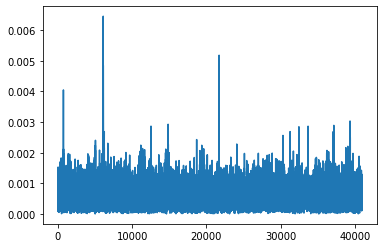

In [24]:
# start training
for epoch in range(epochs):
    total_train_loss = train(model, optimizer)
    
    print('Epoch:%3d'%epoch, '|Train Loss:%8.30f'%(total_train_loss/train_batch_num))
    
    NN_output_train = valid(model)
    NN_output_train = NN_output_train.cpu().numpy() #from tensor back to numpy.ndarray
    NN_output_train = NN_output_train[:,0] + 1j * NN_output_train[:,1] 

    train_NMSE = 10*np.log10(np.sum(np.square(np.abs(inDataPA_train[P_DPD-1:]-NN_output_train)))/np.sum(np.square(np.abs(inDataPA_train[P_DPD-1:]))))
    #train_NMSE = np.sum(np.square(np.abs(inDataPA_train[P_DPD-1:]-NN_output_train)))/np.sum(np.square(np.abs(inDataPA_train[P_DPD-1:])))
    print('train_NMSE:',train_NMSE)

print("---------------------------------------")    
print("-------------saving model--------------")
# save the model
torch.save(model, "model.pth")

#########################
print("train_var:",np.var(np.abs(inDataPA_train[P_DPD-1:]-NN_output_train)))
print("train_mean:",np.mean(np.abs(inDataPA_train[P_DPD-1:]-NN_output_train)))
#plot training error
NN_output_train = valid(model)
NN_output_train = NN_output_train.cpu().numpy() #from tensor back to numpy.ndarray
NN_output_train = NN_output_train[:,0] + 1j * NN_output_train[:,1] 
plt.plot(range(num_train_data-P_DPD+1),np.abs(inDataPA_train[P_DPD-1:]-NN_output_train))

########################test_NMSE_indirect
complex_gain = np.dot(np.conj(inDataPA_test),np.transpose(outDataPA_test)) / np.dot(np.conj(outDataPA_test),np.transpose(outDataPA_test))
outDataPA_test = outDataPA_test*complex_gain

outDataPA_test_real = np.real(outDataPA_test)
outDataPA_test_imag = np.imag(outDataPA_test)

test_input = np.zeros((num_test_data-P_DPD+1,2*P_DPD))

for i in range(P_DPD):
    test_input[:,i] = outDataPA_test_real[P_DPD-1-i:num_test_data-i]
    test_input[:,i+P_DPD] = outDataPA_test_imag[P_DPD-1-i:num_test_data-i]

test_input = torch.from_numpy(test_input)    

with torch.no_grad():
    model.eval()

    input = test_input
    input = input.to(device)

    NN_output_test = model(input)
    
    NN_output_test = NN_output_test.cpu().numpy() #from tensor back to numpy.ndarray
    NN_output_test = NN_output_test[:,0] + 1j * NN_output_test[:,1] 

    test_NMSE_indirect = 10*np.log10(np.sum(np.square(np.abs(inDataPA_test[P_DPD-1:]-NN_output_test)))/np.sum(np.square(np.abs(inDataPA_test[P_DPD-1:]))))

    print('test_NMSE_indirect:',test_NMSE_indirect)    

# Testing 

### Testing function

In [25]:
def test(model):
    test_input = np.zeros((num_test_data-P_DPD+1,2*P_DPD))

    for i in range(P_DPD):
        test_input[:,i] = inDataPA_test_real[P_DPD-1-i:num_test_data-i]
        test_input[:,i+P_DPD] = inDataPA_test_imag[P_DPD-1-i:num_test_data-i]

    test_input = torch.from_numpy(test_input)    
        
    with torch.no_grad():
        model.eval()
        
        input = test_input
        input = input.to(device)

        output = model(input)
            
    return output

### Save NN output

In [26]:
NN_output_test = test(model)

NN_output_test = NN_output_test.cpu().numpy() #from tensor back to numpy.ndarray
NN_output_test = NN_output_test[:,0] + 1j * NN_output_test[:,1] 

sio.savemat('NN_DPD_output_Pytorch.mat', mdict={'NN_output_test': NN_output_test})

print("NN_output_test.shape",NN_output_test.shape)

NN_output_test.shape (40958,)
